# E10s testing for Beta 51 week 8: Main analysis

(This covers data from 2017-01-11 to 2017-01-18 on Beta 51)

## Data processing

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import math
import plotly.plotly as py
import IPython
import pyspark.sql.functions as fun
import pyspark.sql.types as st
from pyspark.sql import Row

from __future__ import division
from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from montecarlino import grouped_permutation_test

%pylab inline
IPython.core.pylabtools.figsize(16, 7)
seaborn.set_style('whitegrid')

from operator import add
pd.set_option("display.max_rows", None)

/home/hadoop/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Unable to parse whitelist (/home/hadoop/anaconda2/lib/python2.7/site-packages/moztelemetry/histogram-whitelists.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.defaultParallelism

320

In [3]:
sc.version

u'1.6.1'

In [4]:
def chi2_distance(xs, ys, eps = 1e-10, normalize = True):
    """ The comparison metric for histograms. """
    histA = xs.sum(axis=0)
    histB = ys.sum(axis=0)
    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d

def median_diff(xs, ys):
    return np.median(xs) - np.median(ys)

def make_group_histogram(group_data):
    """ Combine separate client histograms into a single group histogram, normalizing bin counts
        to relative frequencies.       
    """
    ## Check for histograms with 0 counts.
    client_totals = group_data.map(lambda x: x.sum())
    group_data = group_data[client_totals > 0]
    ## Convert frequency counts to relative frequency for each client histogram.
    group_data = group_data.map(lambda x: x/x.sum())
    ## Merge the group's client histograms by adding up the frequencies over all clients
    ## in the group, separately for each bin.
    group_data = group_data.sum()
    ## Convert the merged bin frequencies to relative percentages.
    group_data = 100 * group_data / group_data.sum()
    return group_data
    

def compare_histogram(histogram, e10s_addons, none10s_addons, e10s_std=None, none10s_std=None,
                      include_diff=True, include_diff_in_diff=True, did_separate_plot=True):
    """ Compare an e10s histogram to a non-e10s one, and graph the results.
        
        Plots the two histograms overlaid on the same graph, and prints a p-value
        for testing whether they are different. If 'include_diff' is True, also
        draw a plot of the frequency differences for each bin.
        
        If 'include_diff_in_diff' is True and data is supplied, include a plot of
        differences between addon cohort differences and non-addon cohort differences.
    """
    eTotal = make_group_histogram(e10s_addons)
    nTotal = make_group_histogram(none10s_addons)
    
    if include_diff:
        if include_diff_in_diff and did_separate_plot:
            fig, (ax, diff_ax, diff_diff_ax) = plt.subplots(3, sharex=True, figsize=(16,10), 
                                                            gridspec_kw={"height_ratios": [2,2,1]})
        else:
            fig, (ax, diff_ax) = plt.subplots(2, sharex=True)
    else:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        
    fig.subplots_adjust(hspace=0.3)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width,
                position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non-e10s", ax=ax2, width=width,
                position=1, grid=False, ylim=ax.get_ylim())
    
    ## Combine legend info from both Axes.
    ax_h, ax_l = ax.get_legend_handles_labels()
    ax2_h, ax2_l = ax2.get_legend_handles_labels()
    ax.legend(ax_h + ax2_h, ax_l + ax2_l, loc = 0)
 
    plt.title(histogram)
    ax.xaxis.grid(False)
    ax.set_ylabel("Frequency %")

    if include_diff:
        ## Add a second barplot of the difference in frequency for each bucket.
        #diff_ax = fig.add_subplot(2, 1, 2)
        enDiff = eTotal - nTotal
        
        has_diff_in_diff_data = (e10s_std is not None and len(e10s_std) > 0 and
                                 none10s_std is not None and len(none10s_std) > 0)
        if include_diff_in_diff and has_diff_in_diff_data:
            ## Add bin differences for between e10s/non-e10s for the no-addons cohorts.
            ## The assumption is that the difference between addons cohorts would look the same
            ## if there is no additional effect of having addons.
            eTotal_std = make_group_histogram(e10s_std)
            nTotal_std = make_group_histogram(none10s_std)
            enDiff_std = eTotal_std - nTotal_std
            ylims = (min(enDiff.min(), enDiff_std.min()) - 0.5, max(enDiff.max(), enDiff_std.max()) + 0.5)
            diff_ax2 = diff_ax.twinx()
            
            enDiff.plot(kind="bar", alpha=0.5, color="navy", label="with add-ons", ax=diff_ax, width=width,
                        position=1, ylim=ylims)
            enDiff_std.plot(kind="bar", alpha=0.5, color="gray", label="no add-ons", ax=diff_ax2, width=width,
                        position=0, grid=False, ylim=diff_ax.get_ylim())

            ## Combine legend info from both Axes.
            diff_ax_h, diff_ax_l = diff_ax.get_legend_handles_labels()
            diff_ax2_h, diff_ax2_l = diff_ax2.get_legend_handles_labels()
            leg_h = diff_ax_h + diff_ax2_h
            leg_l = diff_ax_l + diff_ax2_l
            
            if did_separate_plot:
                enDiffDiff = enDiff - enDiff_std
                enDiffDiff.plot(kind="bar", alpha=0.5, color="maroon", ax=diff_diff_ax, ylim=diff_ax.get_ylim())
                diff_diff_ax.xaxis.grid(False)
                diff_diff_ax.set_ylabel("Diff in freq %")
                diff_diff_ax.set_title("Diff between e10s/non diff with add-ons and e10s/non diff without" +
                                      " (with add-ons higher when > 0)")
            
        else:
            if include_diff_in_diff:
                ## We wanted to do the additional comparison, but there wasn't enough data.
                print("\nNo diff-in-diff comparison: one of the standard cohorts has no non-missing observations.")
            enDiff.plot(kind="bar", alpha=0.5, color="navy", label="with add-ons", ax=diff_ax)
            leg_h, leg_l = diff_ax.get_legend_handles_labels()
        
        plt.title("e10s/non-e10s difference (more e10s in bucket when > 0)")
        diff_ax.xaxis.grid(False)
        diff_ax.set_ylabel("Diff in frequency %")
        diff_ax.legend(leg_h, leg_l, loc = 0)
    
    
    # Only display at most 100 tick labels on the x axis.
    xticklabs = plt.gca().get_xticklabels()
    max_x_ticks = 100
    if len(xticklabs) > max_x_ticks:
        step_size = math.ceil(float(len(xticklabs)) / max_x_ticks)
        for i, tl in enumerate(xticklabs):
            if i % step_size != 0:
                tl.set_visible(False)
    plt.show()
    
    ## Compute a p-value for the chi-square distance between the groups' combined histograms.
    pvalue = grouped_permutation_test(chi2_distance, [e10s_addons, none10s_addons], num_samples=100)
    print("The probability that the distributions for {} (with add-ons) are differing by chance is {:.3f}."\
          .format(histogram, pvalue))

def normalize_uptime_hour(frame):
    """ Convert metrics to rates per hour of uptime. """
    frame = frame[frame["payload/simpleMeasurements/totalTime"] > 60]
    frame = 60 * 60 * frame.apply(lambda x: x / frame["payload/simpleMeasurements/totalTime"]) # Metric per hour
    frame.drop('payload/simpleMeasurements/totalTime', axis=1, inplace=True)
    return frame
    
def compare_e10s_count_histograms(pings, cohort_sizes = {}, *histogram_names, **kwargs):
    """ Read multiple count histograms from a collection of pings, and compare e10s/non-e10s for each.
    
        Treats count histograms as scalars for comparison purposes, without distinguishing between
        parent and child processes. Expects a dict containing overall cohort sizes
        for computing sample size proportions.
    """
    properties = histogram_names + ("payload/simpleMeasurements/totalTime", "e10s", "addons")
    frame = pd.DataFrame(get_pings_properties(pings, properties).collect())
    
    e10s = frame[frame["addons"] & frame["e10s"]]
    e10s = normalize_uptime_hour(e10s)
    
    none10s = frame[frame["addons"] & ~frame["e10s"]]
    none10s = normalize_uptime_hour(none10s)
    
    include_diff_in_diff = kwargs.get("include_diff_in_diff", True)
    if include_diff_in_diff:
        e10s_std = normalize_uptime_hour(frame[~frame["addons"] & frame["e10s"]])
        none10s_std = normalize_uptime_hour(frame[~frame["addons"] & ~frame["e10s"]])        
    
    for histogram in histogram_names:
        if histogram not in none10s.columns:
            continue
        
        ## Remove the property path from the histogram name for display purposes.
        hist_name = hist_base_name(histogram)
        if type(hist_name) == list:
            ## Key was given for keyed histogram.
            hist_str = "{}/{}".format(link_to_histogram(hist_name[0]), hist_name[1])
            hist_name = hist_name[0]
        else:
            hist_str = hist_name
        ## Print a header for the block of graphs, including a link to the histogram definition.
        print_with_markdown("Comparison for count histogram {} (with add-ons):".format(hist_str))
        
        e10s_hist = e10s[histogram].dropna()
        non_e10s_hist = none10s[histogram].dropna()
        
        ## Print some information on sample sizes.
        print("{} non-e10s profiles have this histogram.".format(
                sample_size_str(len(non_e10s_hist), cohort_sizes.get("addons-set2a-control"))))
        print("{} e10s profiles have this histogram.".format(
                sample_size_str(len(e10s_hist), cohort_sizes.get("addons-set2a-test"))))
        ## If either group has no data, nothing more to do.
        if len(non_e10s_hist) == 0 or len(e10s_hist) == 0:
            continue
        
        print("")
        compare_scalars(hist_name + " per hour", e10s_hist, non_e10s_hist,
                        e10s_std[histogram].dropna() if include_diff_in_diff else None,
                        none10s_std[histogram].dropna() if include_diff_in_diff else None)
 
def compare_e10s_histograms(pings, cohort_sizes = {}, *histogram_names, **kwargs):
    """ Read multiple histograms from a collection of pings, and compare e10s/non-e10s for each.
    
        Outputs separate comparisons for parent process, child processes, and merged histograms.
        Expects a dict containing overall cohort sizes for computing sample
        size proportions.
    """
    ## Load histogram data from the ping set, separating parent & child processes for e10s.
    frame = pd.DataFrame(get_pings_properties(pings, histogram_names + ("e10s", "addons") , with_processes=True)\
        .collect())
    ## The addons experiment cohorts.
    e10s_addons = frame[frame["addons"] & frame["e10s"]]
    none10s_addons = frame[frame["addons"] & ~frame["e10s"]]
    ## The standard experiment cohorts.
    e10s_std = frame[~frame["addons"] & frame["e10s"]]
    none10s_std = frame[~frame["addons"] & ~frame["e10s"]]
    
    for histogram in histogram_names:
        if histogram not in none10s_addons.columns:
            continue
        
        ## Remove the property path from the histogram name for display purposes.
        hist_name = hist_base_name(histogram)
        if type(hist_name) == list:
            ## Key was given for keyed histogram.
            hist_str = "{}/{}".format(link_to_histogram(hist_name[0]), hist_name[1])
            hist_name = hist_name[0]
        else:
            hist_str = hist_name
        ## Print a header for the block of graphs, including a link to the histogram definition.
        print_with_markdown("Comparison for {} (with add-ons):".format(hist_str))
        
        ## Compare the main histogram for non-e10s against each of 3 for e10s.
        addons_hist_data = {
            "non_e10s": none10s_addons[histogram],
            "e10s_merged": e10s_addons[histogram],
            "e10s_parent": e10s_addons[histogram + "_parent"],
            "e10s_children": e10s_addons[histogram + "_children"]
        }
        for htype in addons_hist_data:
            addons_hist_data[htype] = addons_hist_data[htype].dropna()
        
        ## Print some information on sample sizes.
        sample_sizes = { htype: len(hdata) for htype, hdata in addons_hist_data.iteritems() }
        print("{} non-e10s profiles have this histogram.".format(
                sample_size_str(sample_sizes["non_e10s"], cohort_sizes.get("addons-set2a-control"))))
        print("{} e10s profiles have this histogram.".format(
                sample_size_str(sample_sizes["e10s_merged"], cohort_sizes.get("addons-set2a-test"))))
        ## If either group has no data, nothing more to do.
        if sample_sizes["non_e10s"] == 0 or sample_sizes["e10s_merged"] == 0:
            continue
        
        print("{} e10s profiles have the parent histogram.".format(
                sample_size_str(sample_sizes["e10s_parent"], cohort_sizes.get("addons-set2a-test"))))
        print("{} e10s profiles have the children histogram.".format(
                sample_size_str(sample_sizes["e10s_children"], cohort_sizes.get("addons-set2a-test"))))
        
        has_parent = sample_sizes["e10s_parent"] > 0
        has_children = sample_sizes["e10s_children"] > 0
        
        non_e10s_std_hist = none10s_std[histogram].dropna()
        
        ## Compare merged histograms, unless e10s group has either no parents or no children.
        if has_children and has_parent:
            compare_histogram(hist_name + " (e10s merged)", 
                              addons_hist_data["e10s_merged"],
                              addons_hist_data["non_e10s"],
                              e10s_std[histogram].dropna(),
                              non_e10s_std_hist,
                              **kwargs)
        
        if has_parent:
            compare_histogram(hist_name + " (parent)",
                              addons_hist_data["e10s_parent"],
                              addons_hist_data["non_e10s"],
                              e10s_std[histogram + "_parent"].dropna(),
                              non_e10s_std_hist,
                              **kwargs)

        if has_children:
            compare_histogram(hist_name + " (children)",
                              addons_hist_data["e10s_children"],
                              addons_hist_data["non_e10s"],
                              e10s_std[histogram + "_children"].dropna(),
                              non_e10s_std_hist,
                              **kwargs)

def compare_scalars(metric, e10s_data, non_e10s_data, e10s_std=None, non_e10s_std=None, unit="units"):
    """ Prints info about the median difference between the groups, together with a p-value
        for testing the difference.
        
        Optionally include a string indicating the units the metric is measured in.
        If data is supplied, also print a comparison for non-addons cohorts.
    """
    e10s_data = e10s_data.dropna()
    non_e10s_data = non_e10s_data.dropna()
    if len(e10s_data) == 0 or len(non_e10s_data) == 0:
        print("Cannot run comparison: one of the groups has no non-missing observations.")
        return
    
    print("Comparison for {}{} (with add-ons):\n".format(metric, " ({})".format(unit) if unit != "units" else ""))
    e10s_median = np.median(e10s_data)
    non_e10s_median = np.median(non_e10s_data)
    mdiff = median_diff(e10s_data, non_e10s_data)
    print("- Median with e10s is {:.3g} {} {} median without e10s."\
         .format(
            #abs(mdiff),
            mdiff,
            unit,
            #"higher than" if mdiff >= 0 else "lower than"
            "different from"))
    print("- This is a relative difference of {:.1f}%.".format(float(mdiff) / non_e10s_median * 100))
    print("- E10s group median is {:.4g}, non-e10s group median is {:.4g}.".format(e10s_median, non_e10s_median))
            
    print("\nThe probability of this difference occurring purely by chance is {:.3f}."\
        .format(grouped_permutation_test(median_diff, [e10s_data, non_e10s_data], num_samples=10000)))
    
    if e10s_std is not None and non_e10s_std is not None:
        ## Include a comparison between non-addon cohorts.
        e10s_std = e10s_std.dropna()
        non_e10s_std = non_e10s_std.dropna()
        if len(e10s_std) > 0 and len(non_e10s_std) > 0:
            non_e10s_std_median = np.median(non_e10s_std)
            e10s_std_median = np.median(e10s_std)
            mdiff_std = median_diff(e10s_std, non_e10s_std)
            print("\nFor cohorts with no add-ons, median with e10s is {:.3g} {} ({:.1f}%) {} median without"\
                 .format(
                    #abs(mdiff_std),
                    mdiff_std,
                    unit,
                    float(mdiff_std) / non_e10s_std_median * 100,
                    #"higher than" if mdiff_std >= 0 else "lower than"
                    "different from"))
            print("- This is a relative difference of {:.1f}%."\
                  .format(float(mdiff_std) / non_e10s_std_median * 100))
            print("- E10s group median is {:.4g}, non-e10s group median is {:.4g}."\
                  .format(e10s_std_median, non_e10s_std_median))

    
def link_to_histogram(hist_name):
    """ Create a link to the histogram definition in Markdown. """
    return "[{}](https://dxr.mozilla.org/mozilla-central/search?q={}+file%3AHistograms.json&redirect=true)"\
            .format(hist_name, hist_name)

def hist_base_name(path_to_histogram):
    """ Remove any path components from histogram name.
    
        If histogram is specified as a path in the payload, with separator '/',
        remove everything but the last component (the actual name).
        However, if the histogram is keyed, and specified with a key, return
        [histname, key].
    """
    path_to_histogram = path_to_histogram.rsplit("/")
    if len(path_to_histogram) > 1 and path_to_histogram[-3] == "keyedHistograms":
        ## There was a keyedHistogram name and key given.
        return path_to_histogram[-2:]
    return path_to_histogram[-1]

## Hack to render links in code output.
from IPython.display import Markdown, display
def print_with_markdown(md_text):
    """ Print Markdown text so that it renders correctly in the cell output. """
    display(Markdown(md_text))

def sample_size_str(sample_size, cohort_size=None):
    """ Convert a sample size to a string representation, including a percentage if available. """
    if sample_size == 0:
        return "No"
    if cohort_size:
        if sample_size == cohort_size:
            return "All"
        return "{} ({:.1f}%)".format(sample_size, float(sample_size) / cohort_size * 100)
    return str(sample_size)

### Get e10s/non-e10s cohorts for the add-ons experiment

The derived dataset is computed from profiles on Beta 50 who have e10sCohort set. It contains a single record (ping) per client, which is randomly selected from among the client's pings during the date range.

In [5]:
# regenerated data and loaded into telemetry-test-bucket
dataset = sqlContext.read.parquet(
    "s3://telemetry-parquet/e10s_experiment_view/e10s_addons_beta51_cohorts/v20170111_20170118/")
dataset.printSchema()

root
 |-- clientId: string (nullable = false)
 |-- e10sCohort: string (nullable = false)
 |-- creationTimestamp: string (nullable = false)
 |-- submissionDate: string (nullable = false)
 |-- documentId: string (nullable = false)
 |-- sampleId: integer (nullable = false)
 |-- buildId: string (nullable = false)
 |-- simpleMeasurements: string (nullable = false)
 |-- settings: string (nullable = false)
 |-- addons: string (nullable = false)
 |-- system: string (nullable = false)
 |-- build: string (nullable = false)
 |-- threadHangStats: string (nullable = false)
 |-- histograms: string (nullable = false)
 |-- keyedHistograms: string (nullable = false)
 |-- childPayloads: string (nullable = false)
 |-- processes: string (nullable = false)



How many records are in the overall dataset?

In [6]:
dataset.count()

3109292

What are the cohorts, and how many clients do we have in each cohort?

In [7]:
%time cohort_counts = dataset.groupby("e10sCohort").count().collect()
dataset_count = sum(map(lambda r: r["count"], cohort_counts))

def cohort_proportions(r):
    prop = r["count"] * 100.0 / dataset_count
    return (r["e10sCohort"], r["count"], "{:.2f}%".format(prop))

print("\nTotal number of clients: {:,}".format(dataset_count))
sorted(map(cohort_proportions, cohort_counts), key = lambda r: r[0])

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.76 s

Total number of clients: 3,109,292


[(u'-1', 1, '0.00%'),
 (u'addons-set2a-test', 1, '0.00%'),
 (u'addons-set49a-test', 4, '0.00%'),
 (u'addons-set50allmpc-control', 2882, '0.09%'),
 (u'addons-set50allmpc-test', 2801, '0.09%'),
 (u'addons-set51alladdons-control', 552333, '17.76%'),
 (u'addons-set51alladdons-test', 541122, '17.40%'),
 (u'control', 775669, '24.95%'),
 (u'disqualified', 13, '0.00%'),
 (u'disqualified-control', 228777, '7.36%'),
 (u'disqualified-test', 226552, '7.29%'),
 (u'optedIn', 7086, '0.23%'),
 (u'optedOut', 20125, '0.65%'),
 (u'temp-disqualified-ru', 12, '0.00%'),
 (u'test', 747586, '24.04%'),
 (u'unknown', 4244, '0.14%'),
 (u'unsupportedChannel', 84, '0.00%')]

In [8]:
ADDONS_TEST_COHORT = u'addons-set51alladdons-test'
ADDONS_CONTROL_COHORT = u'addons-set51alladdons-control'

Restrict to pings belonging to the e10s add-ons experiment. Also include the standard e10s test/control for comparison.

In [9]:
addons_exp_dataset = dataset.filter(\
"e10sCohort in ('%s','%s', 'test', 'control')" % (ADDONS_TEST_COHORT, ADDONS_CONTROL_COHORT))

How many clients are left?

In [10]:
addons_exp_dataset.count()

2616710

We want to make sure that the pings tagged into the cohorts satisfy the basic assumptions of the experiment, as this not guaranteed. All add-ons cohort pings should have active add-ons, and e10s should be enabled if and only if the ping belongs to the test cohort.

In [11]:
def e10s_status_check(settings, addons):
    """ Check whether e10s is enabled, and whether there are add-ons. """
    e10sEnabled = json.loads(settings).get("e10sEnabled")
    active_addons = json.loads(addons).get("activeAddons")
    return Row(
        e10s_enabled = bool(e10sEnabled), 
        has_addons = bool(active_addons)
    )

def bad_ping(cohort, settings, addons):
    """ e10s should be enabled iff the profile is in the test cohort, and profiles should have active add-ons
        if they are in the addons cohorts. 
    """
    check_data = e10s_status_check(settings, addons)
    is_bad = cohort.endswith("test") != check_data.e10s_enabled
    if cohort.startswith("addons"):
        is_bad = is_bad or not check_data.has_addons
    return is_bad

## Add a Column to the DF with the outcome of the check.
## This will be used to remove any bad rows after examining them.
from pyspark.sql.types import BooleanType
status_check_udf = fun.udf(bad_ping, BooleanType())
addons_exp_dataset_check = addons_exp_dataset.withColumn("badPing",
    status_check_udf(addons_exp_dataset.e10sCohort, addons_exp_dataset.settings, addons_exp_dataset.addons))

If there are any bad pings, describe the problems and remove them from the dataset.

In [12]:
addons_exp_dataset_bad = addons_exp_dataset_check.filter("badPing")\
    .select("e10sCohort", "settings", "addons")\
    .rdd

has_bad = not addons_exp_dataset_bad.isEmpty()

In [13]:
if not has_bad:
    print("No issues")
else:
    check_counts = addons_exp_dataset_bad\
        .map(lambda r: (r.e10sCohort, e10s_status_check(r.settings, r.addons)))\
        .countByValue()
    print("Issues:")
    for k, v in check_counts.iteritems():
        print("{}: {}".format(k, v))

Issues:
(u'addons-set51alladdons-control', Row(e10s_enabled=True, has_addons=True)): 3
(u'addons-set51alladdons-control', Row(e10s_enabled=False, has_addons=False)): 1610
(u'addons-set51alladdons-test', Row(e10s_enabled=False, has_addons=True)): 116
(u'addons-set51alladdons-test', Row(e10s_enabled=True, has_addons=False)): 551
(u'addons-set51alladdons-test', Row(e10s_enabled=False, has_addons=False)): 2


In [14]:
if has_bad:
    print("\nRemoving these pings from the dataset.")
    addons_exp_dataset = addons_exp_dataset_check.filter("not badPing").drop("badPing")
    print("The dataset now contains {} clients".format(addons_exp_dataset.count()))


Removing these pings from the dataset.
The dataset now contains 2614428 clients


What add-ons are present for the addons cohorts?

In [15]:
def get_active_addon_info(addons_str):
    """ Return a list of currently enabled add-ons in the form (GUID, name, version, isSystem). """
    addons = json.loads(addons_str)
    addons = addons.get("activeAddons", {})
    if not addons:
        return []
    return [(guid, meta.get("name"), meta.get("isSystem"), meta.get('version')) for guid, meta in addons.iteritems()]


def dataset_installed_addons(data, n_top=100):
    """ Extract add-on info from a subset of the main dataset, and generate a table of top add-ons
        with installation counts.
        
        Returns a Pandas DataFrame.
    """
    data_addons = data.select("addons").rdd.map(lambda row: row["addons"])
    data_addons.cache()
    n_in_data = data_addons.count()
    
    ##  Get counts by add-on ID/name/isSystem value.
    addon_counts = data_addons.flatMap(get_active_addon_info)\
        .map(lambda a: (a, 1))\
        .reduceByKey(add)\
        .map(lambda ((guid, name, sys, version), n): (guid, (name, sys, version, n)))
    
    ## Summarize using the most common name and isSystem value.
    top_vals = addon_counts.reduceByKey(lambda a, b: a if a[-1] > b[-1] else b)\
        .map(lambda (guid, (name, sys, version, n)): (guid, (name, sys, version)))
    n_installs = addon_counts.mapValues(lambda (name, sys, version, n): n)\
        .reduceByKey(add)
    addon_info = top_vals.join(n_installs)\
        .map(lambda (guid, ((name, sys, version), n)): {
                "guid": guid,
                "name": name,
                "is_system": sys,
                "version":version,
                "n_installs": n,
                "pct_installed": n / n_in_data * 100
            })\
        .sortBy(lambda info: info["n_installs"], ascending=False)
    
    addon_info_coll = addon_info.collect() if not n_top else addon_info.take(n_top)
    addon_info_table = pd.DataFrame(addon_info_coll)
    addon_info_table = addon_info_table[["guid", "name", "version","is_system", "n_installs", "pct_installed"]]
    ## Number rows from 1.
    addon_info_table.index += 1
    n_addons = addon_info.count()
    data_addons.unpersist()
    return (n_addons, addon_info_table)

In [18]:
def get_top_addons(df, cohort_filter, n_top=100):
    cohort_num, cohort_table = dataset_installed_addons(
        df.filter(cohort_filter),
        n_top=n_top)
    print("There were {:,} distinct add-ons installed across the {} cohort."\
          .format(cohort_num, cohort_filter))

    cohort_table["n_installs"] = cohort_table["n_installs"]
    cohort_table["pct_installed"] = cohort_table["pct_installed"]
    return cohort_table

In [19]:
get_top_addons(addons_exp_dataset, "e10sCohort like 'addons%'")

There were 10,006 distinct add-ons installed across the e10sCohort like 'addons%' cohort.


,guid,name,version,is_system,n_installs,pct_installed
1,aushelper@mozilla.org,Application Update Service Helper,1.0,True,1088918,99.793342
2,webcompat@mozilla.org,Web Compat,1.0,True,1087310,99.645977
3,e10srollout@mozilla.org,Multi-process staged rollout,1.6,True,1085375,99.468645
4,firefox@getpocket.com,Pocket,1.0.5,True,1084569,99.394780
5,{d10d0bf8-f5b5-c8b4-a8b2-2b9879e08c5d},Adblock Plus,2.8.2,False,169255,15.511289
6,_65Members_@download.fromdoctopdf.com,FromDocToPDF,7.102.10.4221,False,78203,7.166875
7,light_plugin_ACF0E80077C511E59DED005056C00008@...,Kaspersky Protection,4.6.3-15,False,62063,5.687732
8,{b9db16a4-6edc-47ec-a1f4-b86292ed211d},Video DownloadHelper,6.2.0,False,59691,5.470352
9,helper-sig@savefrom.net,SaveFrom.net - helper,6.95,False,59605,5.462470
10,{de71f09a-3342-48c5-95c1-4b0f17567554},Search for Firefox,1.2,False,56475,5.175623


What add-ons are present in the standard (non-addons) cohorts, if any?

In [20]:
get_top_addons(addons_exp_dataset, "e10sCohort in ('test', 'control')")

There were 1,072 distinct add-ons installed across the e10sCohort in ('test', 'control') cohort.


,guid,name,version,is_system,n_installs,pct_installed
1,aushelper@mozilla.org,Application Update Service Helper,1.0,True,1496918,98.271005
2,webcompat@mozilla.org,Web Compat,1.0,True,1495588,98.183692
3,e10srollout@mozilla.org,Multi-process staged rollout,1.6,True,1494453,98.109181
4,firefox@getpocket.com,Pocket,1.0.5,True,1494151,98.089355
5,firefox-hotfix@mozilla.org,Firefox Hotfix,20160826.01,False,18260,1.198749
6,www.facebook.com@services.mozilla.org,Facebook,2,None,6092,0.399933
7,mg.mail.yahoo.com@services.mozilla.org,Yahoo Mail,1.0,None,2921,0.191760
8,plus.google.com@services.mozilla.org,Google+,,None,2253,0.147907
9,content_blocker@kaspersky.com,Dangerous Websites Blocker,4.0.10.15,False,1858,0.121976
10,loop@mozilla.org,Firefox Hello,1.2.6,True,1452,0.095322


### Transform Dataframe to RDD of pings

In [21]:
def row_2_ping(row):
    ping = {
        "payload": {"simpleMeasurements": json.loads(row.simpleMeasurements) if row.simpleMeasurements else {},
                    "histograms": json.loads(row.histograms) if row.histograms else {},
                    "keyedHistograms": json.loads(row.keyedHistograms) if row.keyedHistograms else {},
                    "childPayloads": json.loads(row.childPayloads) if row.childPayloads else {},
                    "threadHangStats": json.loads(row.threadHangStats)} if row.threadHangStats else {},
       "e10s": True if row.e10sCohort.endswith("test") else False,
       "addons": True if row.e10sCohort.startswith("addons") else False,
       "system": json.loads(row.system),
       "cohort": row.e10sCohort
    }
    return ping

def notxp(p):
    os = p.get("system", {}).get("os", {})
    return os["name"] != "Windows_NT" or os["version"] != "5.1"

subset = addons_exp_dataset.rdd.map(row_2_ping).filter(notxp)

In [22]:
def add_gecko_activity(ping):
    uptime = ping["payload"].get("simpleMeasurements", {}).get("totalTime", -1) / 60
    if uptime <= 0:
        return ping

    def get_hangs_per_minute(threads, thread_name, uptime):
        for thread in threads:
            if thread["name"] == thread_name:
                activity = thread["activity"]["values"]
                if activity:
                    histogram = pd.Series(activity.values(), index=map(int, activity.keys())).sort_index()
                    # 255 is upper bound for 128-255ms bucket.
                    return histogram[histogram.index >= 255].sum() / uptime
        return None

    threads = ping["payload"].get("threadHangStats", {})
    ping["parent_hangs_per_minute"] = get_hangs_per_minute(threads, "Gecko", uptime)

    child_payloads = ping["payload"].get("childPayloads", [])
    child_hangs_per_minute = []
    for payload in child_payloads:
        child_uptime = payload.get("simpleMeasurements", {}).get("totalTime", -1) / 60
        if child_uptime <= 0:
            continue
        child_threads = payload.get("threadHangStats", {})
        child_hangs = get_hangs_per_minute(child_threads, "Gecko_Child", child_uptime)
        if child_hangs:
            child_hangs_per_minute.append(child_hangs)

    if len(child_hangs_per_minute) > 0:
        ping["child_hangs_per_minute"] = sum(child_hangs_per_minute) / len(child_hangs_per_minute)

    return ping

subset = subset.map(add_gecko_activity)

At this point, how many clients are left in each cohort? Key first by cohort.

In [23]:
subset = subset.map(lambda r: (r["cohort"], r))

cohort_sizes = subset.countByKey()
cohort_sizes

defaultdict(int,
            {u'addons-set51alladdons-control': 503034,
             u'addons-set51alladdons-test': 495749,
             u'control': 680736,
             u'test': 658585})

We include the standard e10s cohorts to provide an additional comparison to the addon cohorts. If we see an e10s-related difference for profiles with add-ons, we want to see whether the difference is specific to having add-ons, or whether it occurs regardless.

Since the addon cohorts are much smaller than the standard ones, we draw samples from the standard ones to make them approximately the same size.

NOTE: **MPC=False should be blocked (see [bug](https://bugzilla.mozilla.org/show_bug.cgi?id=1329695)), temporary fix:**
In Beta 51, we have a much larger cohort size for addons since we do not only take MPC=True, so we will sample 25% of the cohort to approximately match previous cohort sizes. This is necessary to continue the analysis due to memory contraints.

In [24]:
target_prop_test = cohort_sizes[ADDONS_TEST_COHORT] / cohort_sizes["test"]
target_prop_control = cohort_sizes[ADDONS_CONTROL_COHORT] / cohort_sizes["control"]
sampling_props = {
    ADDONS_TEST_COHORT: .25,
    ADDONS_CONTROL_COHORT: .25,
    u"test": target_prop_test * .25,
    u"control": target_prop_control * .25    
}
subset = subset.sampleByKey(False, sampling_props)\
    .persist(StorageLevel.MEMORY_AND_DISK_SER)
    
print 'Sampling the following proportions from each group:'
sampling_props


Sampling the following proportions from each group:


{u'addons-set51alladdons-control': 0.25,
 u'addons-set51alladdons-test': 0.25,
 u'control': 0.18473901776900295,
 u'test': 0.18818717401702134}

Now compute the final cohort sizes, and wrap them into the histogram comparison functions.

In [25]:
e10s_addon_cohort_sizes = subset.countByKey()

## Remove the cohort label key from the dataset.
subset = subset.map(lambda r: r[1])

In [26]:
print("Final cohort sizes:")
print(" - e10s (with add-ons): {}".format(e10s_addon_cohort_sizes[ADDONS_TEST_COHORT]))
print(" - non-e10s (with add-ons): {}".format(e10s_addon_cohort_sizes[ADDONS_CONTROL_COHORT]))
print(" - e10s (no add-ons): {}".format(e10s_addon_cohort_sizes["test"]))
print(" - non-e10s (no add-ons): {}".format(e10s_addon_cohort_sizes["control"]))

def compare_histograms(pings, *histogram_names, **kwargs):
    return compare_e10s_histograms(pings, e10s_addon_cohort_sizes, *histogram_names, **kwargs)
    
def compare_count_histograms(pings, *histogram_names, **kwargs):
    return compare_e10s_count_histograms(pings, e10s_addon_cohort_sizes, *histogram_names, **kwargs)

Final cohort sizes:
 - e10s (with add-ons): 123599
 - non-e10s (with add-ons): 125663
 - e10s (no add-ons): 124109
 - non-e10s (no add-ons): 125620


## 1.3 Jank

Comparison for GC_MAX_PAUSE_MS (with add-ons):

125607 non-e10s profiles have this histogram.
123540 e10s profiles have this histogram.
123539 e10s profiles have the parent histogram.
111611 e10s profiles have the children histogram.


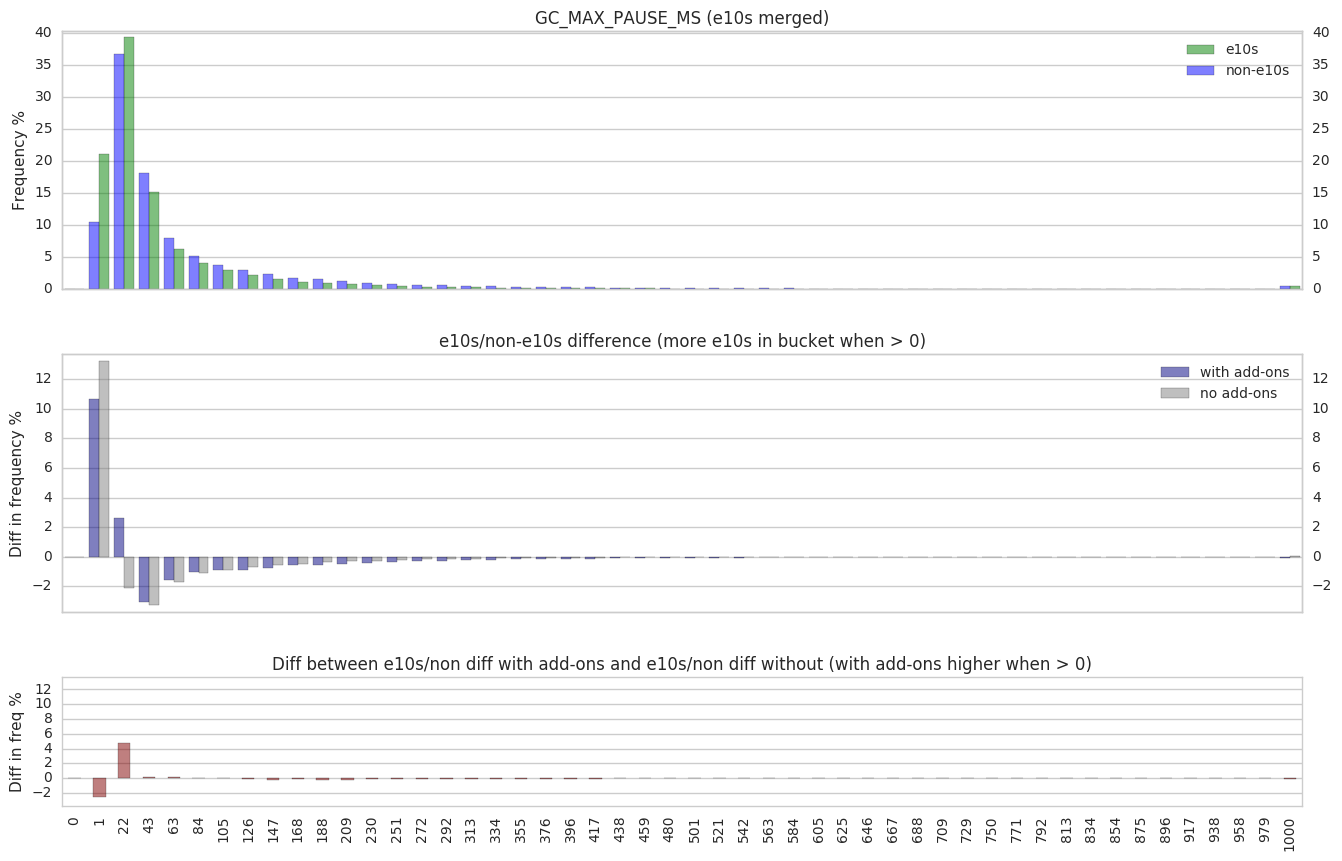

The probability that the distributions for GC_MAX_PAUSE_MS (e10s merged) (with add-ons) are differing by chance is 0.000.


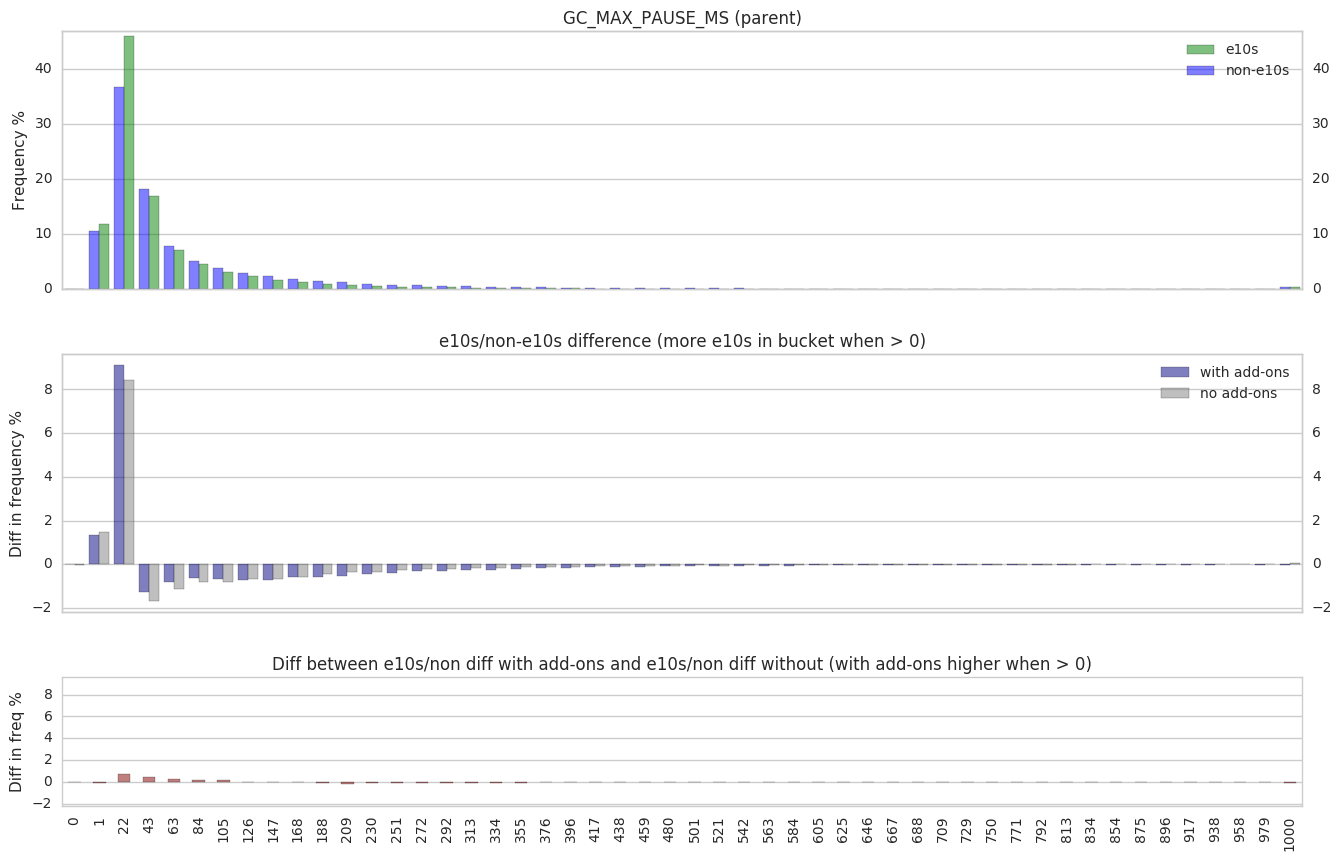

The probability that the distributions for GC_MAX_PAUSE_MS (parent) (with add-ons) are differing by chance is 0.000.


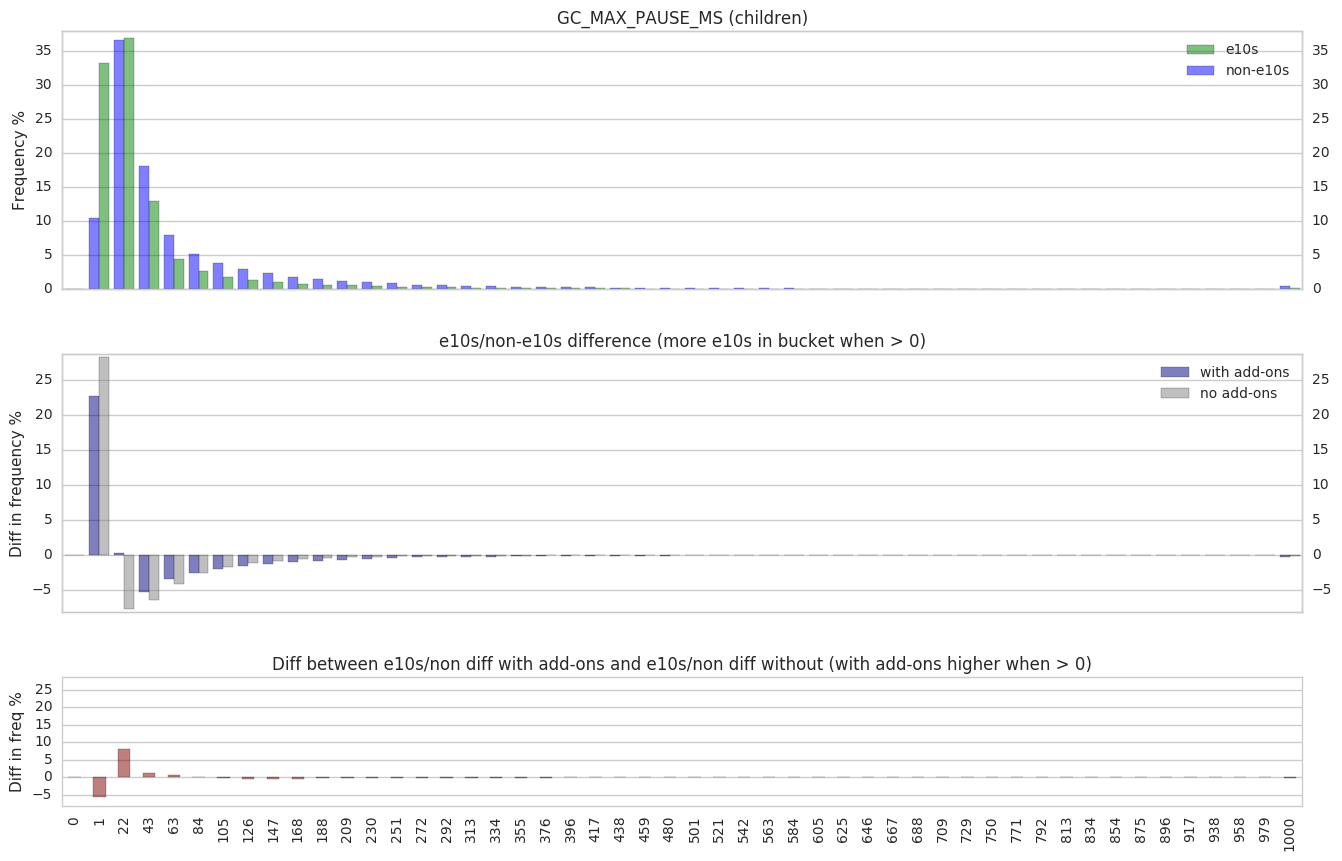

The probability that the distributions for GC_MAX_PAUSE_MS (children) (with add-ons) are differing by chance is 0.000.


Comparison for CYCLE_COLLECTOR_MAX_PAUSE (with add-ons):

118356 non-e10s profiles have this histogram.
116560 e10s profiles have this histogram.
116543 e10s profiles have the parent histogram.
109388 e10s profiles have the children histogram.


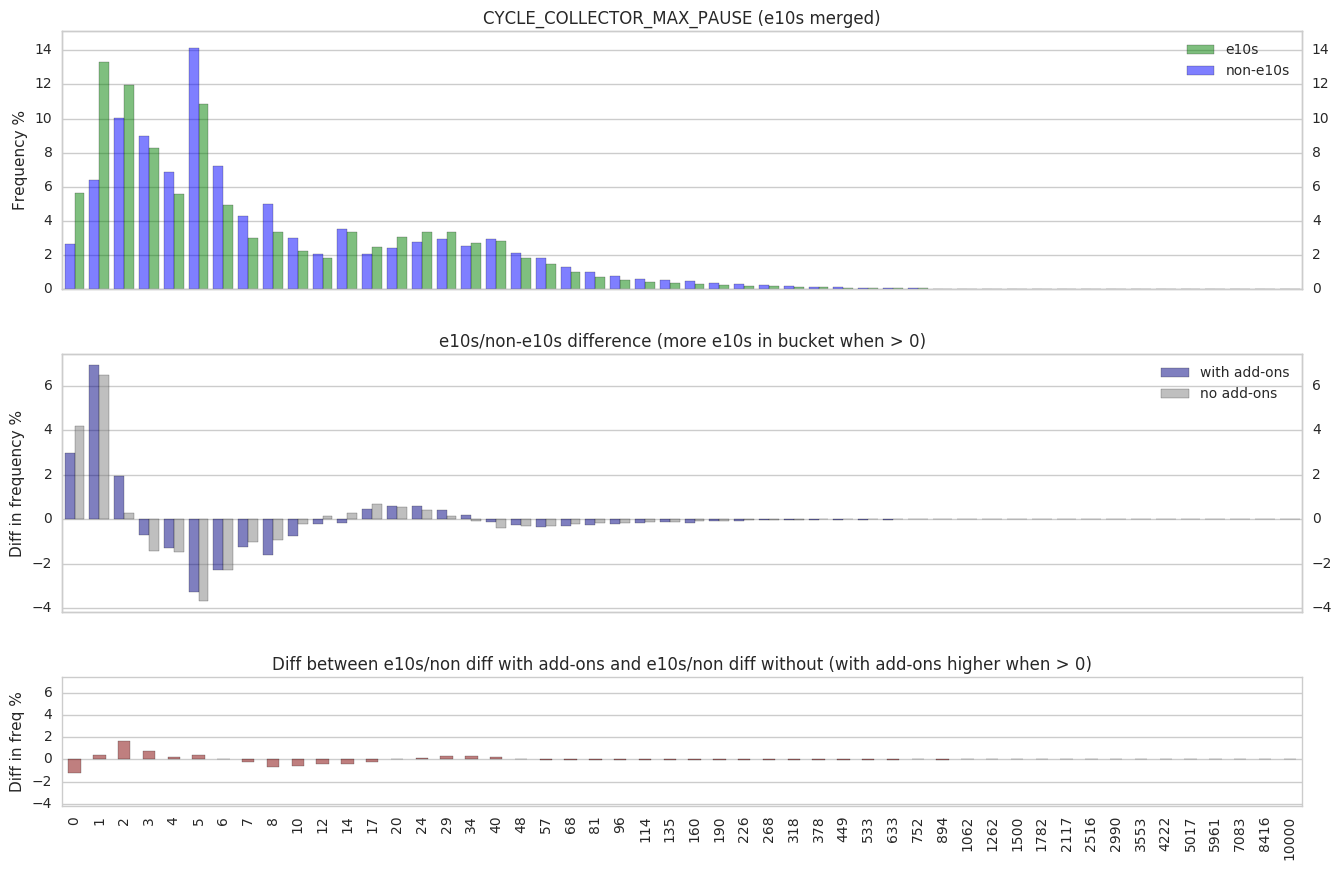

The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (e10s merged) (with add-ons) are differing by chance is 0.000.


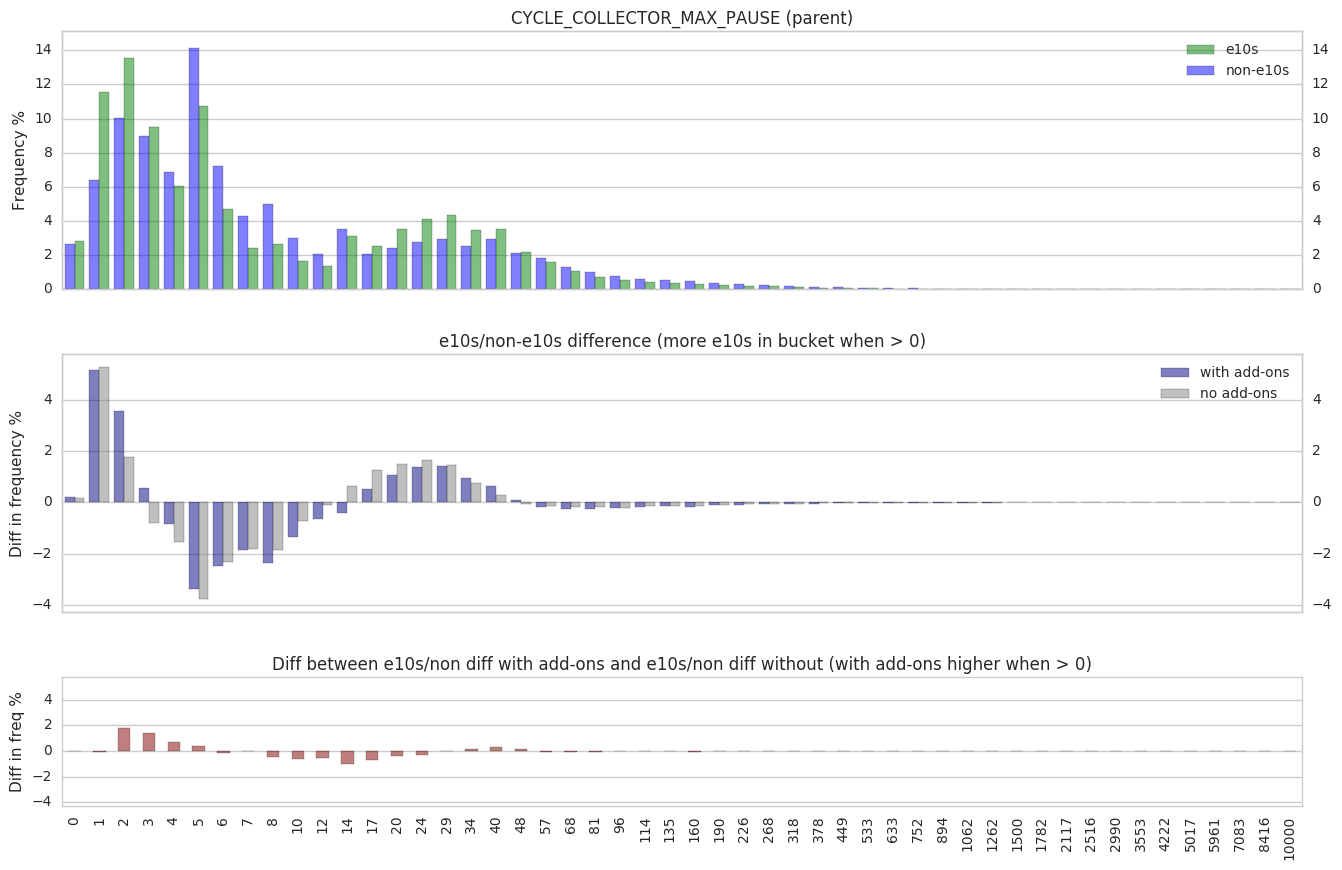

The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (parent) (with add-ons) are differing by chance is 0.000.


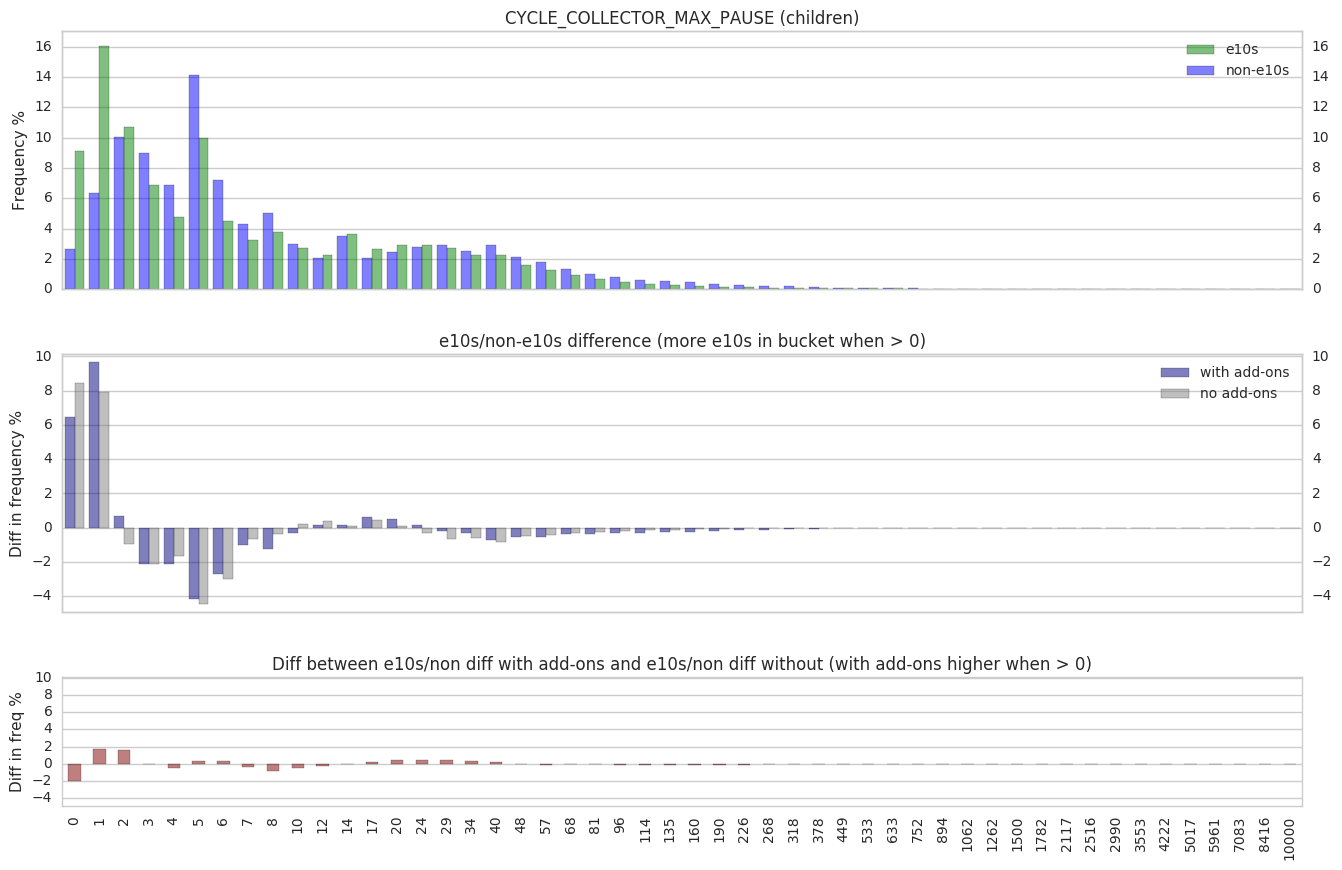

The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (children) (with add-ons) are differing by chance is 0.000.


Comparison for INPUT_EVENT_RESPONSE_MS (with add-ons):

125640 non-e10s profiles have this histogram.
123573 e10s profiles have this histogram.
123573 e10s profiles have the parent histogram.
112332 e10s profiles have the children histogram.


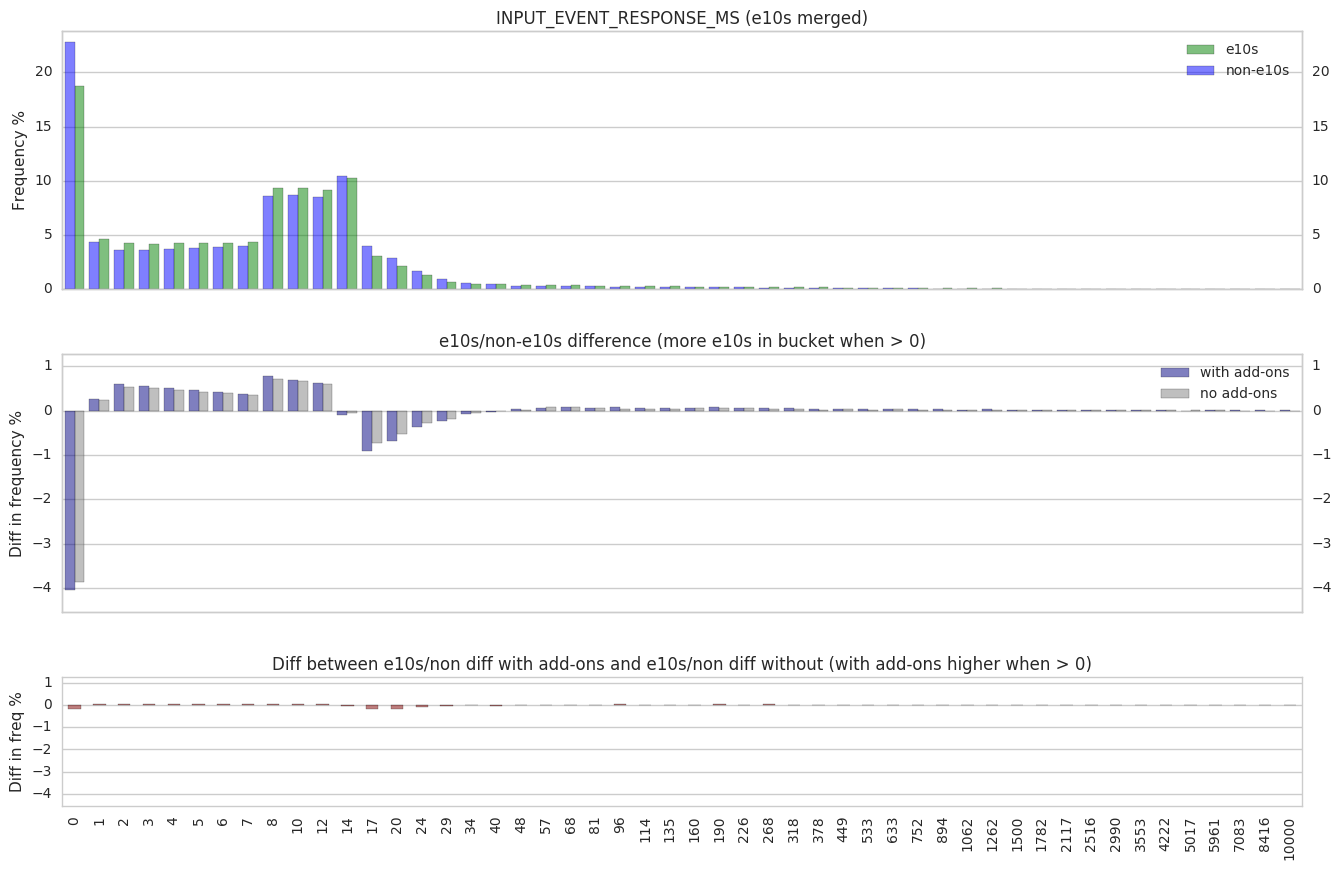

The probability that the distributions for INPUT_EVENT_RESPONSE_MS (e10s merged) (with add-ons) are differing by chance is 0.000.


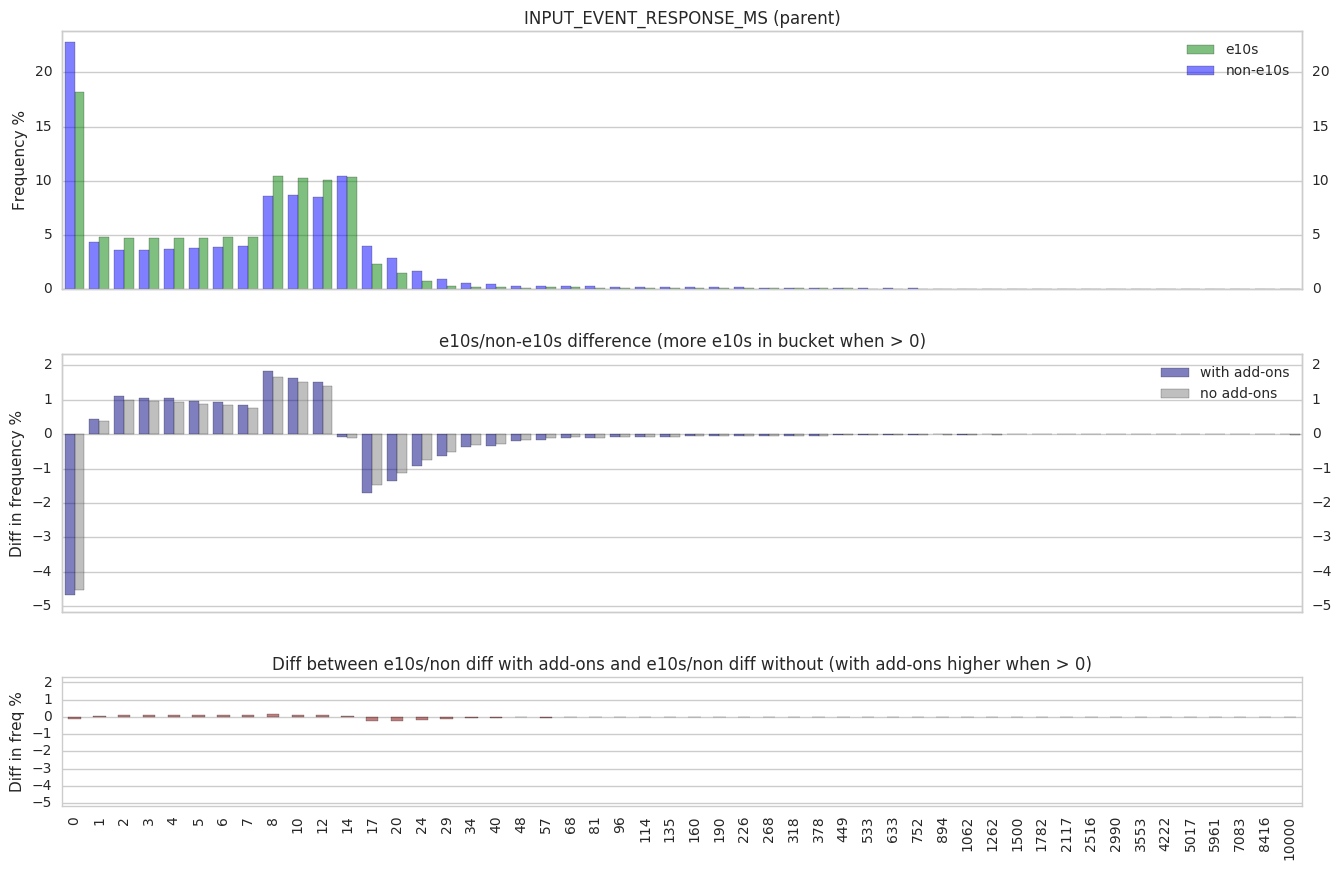

The probability that the distributions for INPUT_EVENT_RESPONSE_MS (parent) (with add-ons) are differing by chance is 0.000.


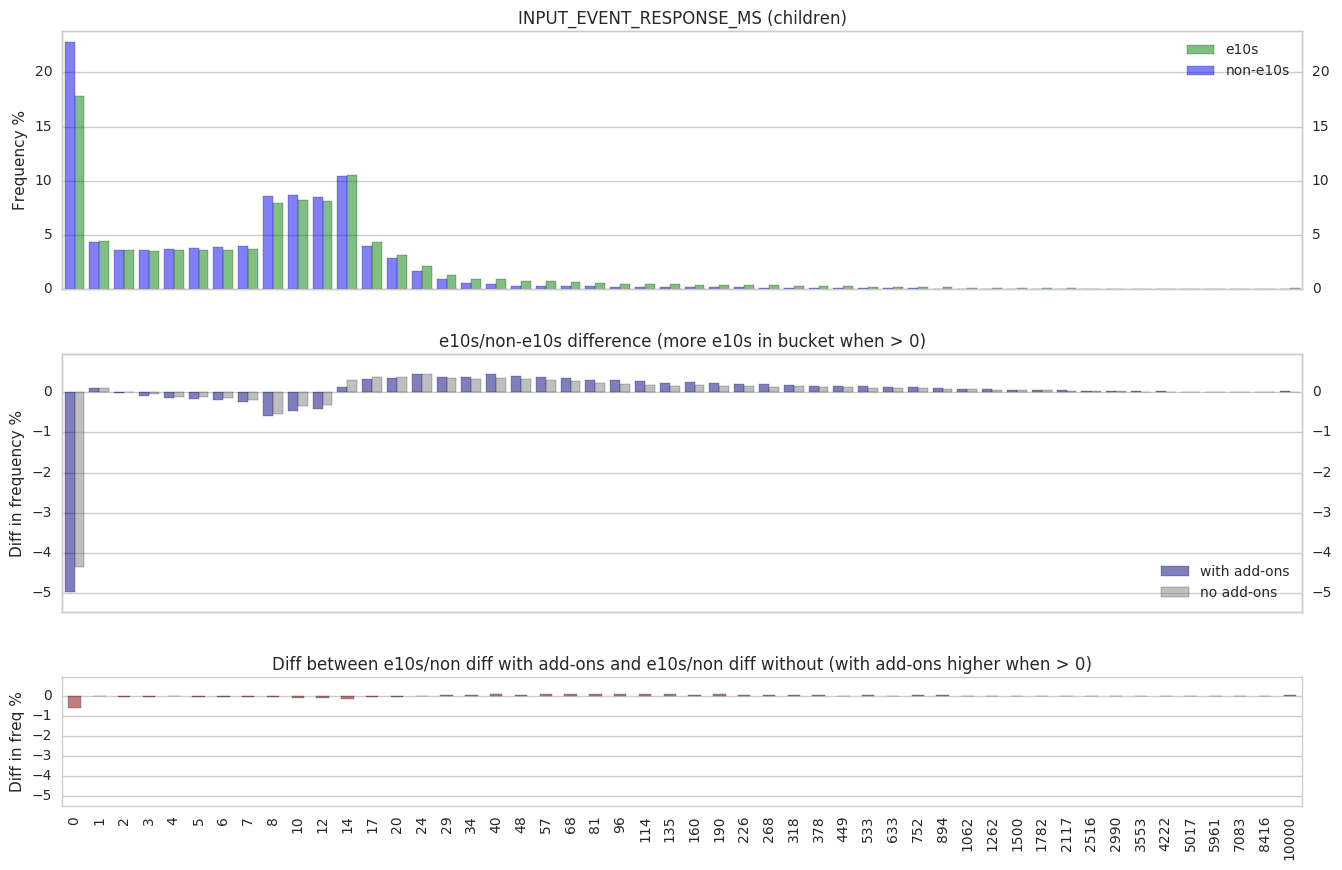

The probability that the distributions for INPUT_EVENT_RESPONSE_MS (children) (with add-ons) are differing by chance is 0.000.


In [27]:
compare_histograms(subset,  
                   "payload/histograms/GC_MAX_PAUSE_MS",
                   "payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE",
                   "payload/histograms/INPUT_EVENT_RESPONSE_MS")

## 1.4 Page load

Comparison for FX_PAGE_LOAD_MS (with add-ons):

122481 non-e10s profiles have this histogram.
123013 e10s profiles have this histogram.
123013 e10s profiles have the parent histogram.
No e10s profiles have the children histogram.


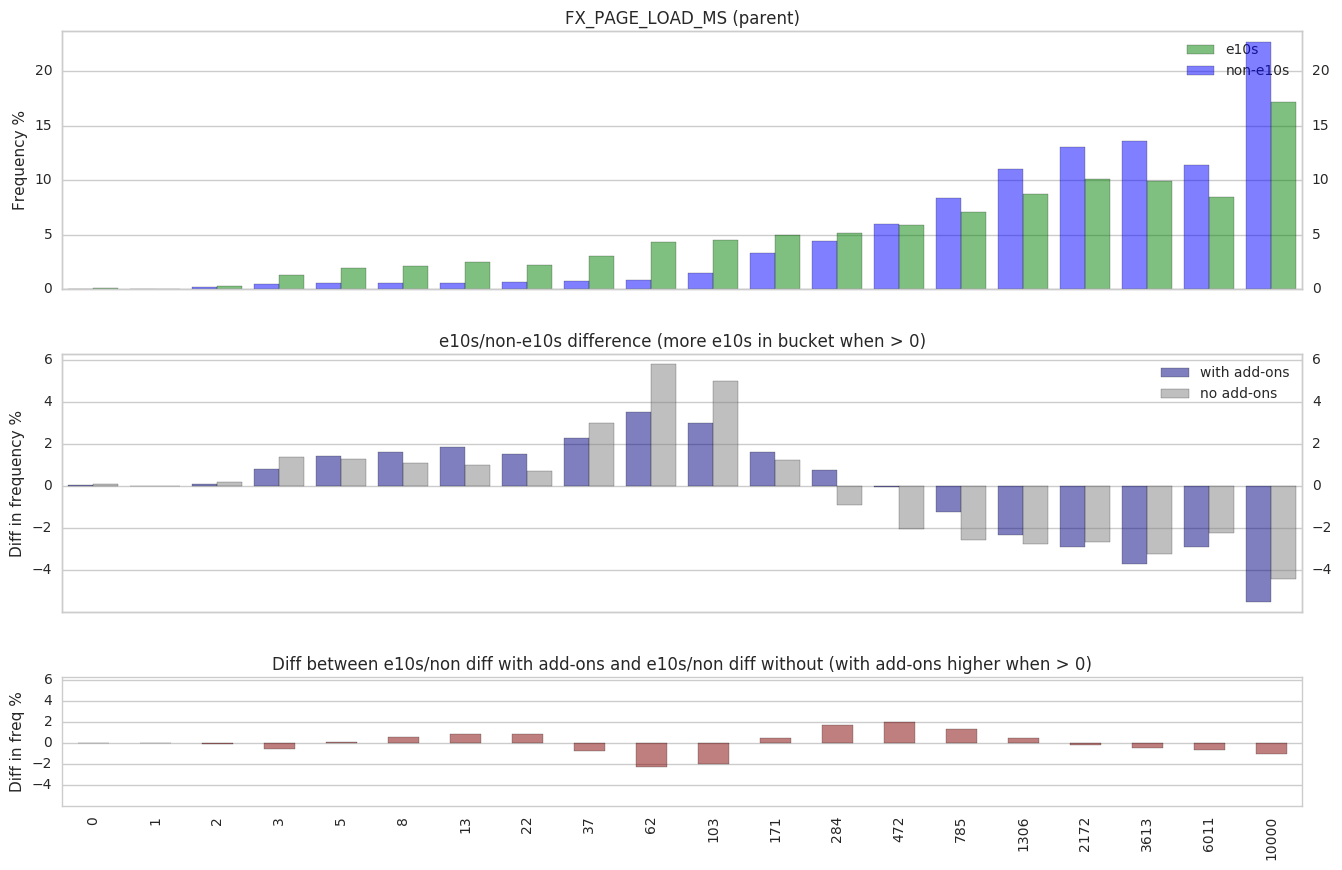

The probability that the distributions for FX_PAGE_LOAD_MS (parent) (with add-ons) are differing by chance is 0.036.


In [28]:
compare_histograms(subset, "payload/histograms/FX_PAGE_LOAD_MS")

## 1.5 Startup/shutdown time

In [29]:
simple = pd.DataFrame(get_pings_properties(subset, [
    "payload/simpleMeasurements/firstPaint",
    "payload/simpleMeasurements/sessionRestored",
    "payload/simpleMeasurements/shutdownDuration",
    "e10s",
    "addons"]).collect())

eSimple = simple[simple["addons"] & simple["e10s"]]
nSimple = simple[simple["addons"] & ~simple["e10s"]]
eSimple_std = simple[~simple["addons"] & simple["e10s"]]
nSimple_std = simple[~simple["addons"] & ~simple["e10s"]]

len(eSimple), len(nSimple), len(eSimple_std), len(nSimple_std)

(123599, 125663, 124109, 125620)

In [30]:
compare_scalars("firstPaint time",
                eSimple["payload/simpleMeasurements/firstPaint"],
                nSimple["payload/simpleMeasurements/firstPaint"],
                eSimple_std["payload/simpleMeasurements/firstPaint"],
                nSimple_std["payload/simpleMeasurements/firstPaint"],
                "ms")

Comparison for firstPaint time (ms) (with add-ons):

- Median with e10s is 173 ms different from median without e10s.
- This is a relative difference of 3.5%.
- E10s group median is 5128, non-e10s group median is 4955.

The probability of this difference occurring purely by chance is 0.000.

For cohorts with no add-ons, median with e10s is 149 ms (3.6%) different from median without
- This is a relative difference of 3.6%.
- E10s group median is 4333, non-e10s group median is 4184.


In [31]:
compare_scalars("sessionRestored time",
                eSimple["payload/simpleMeasurements/sessionRestored"],
                nSimple["payload/simpleMeasurements/sessionRestored"],
                eSimple_std["payload/simpleMeasurements/sessionRestored"],
                nSimple_std["payload/simpleMeasurements/sessionRestored"],
               "ms")

Comparison for sessionRestored time (ms) (with add-ons):

- Median with e10s is -92.5 ms different from median without e10s.
- This is a relative difference of -1.4%.
- E10s group median is 6471, non-e10s group median is 6564.

The probability of this difference occurring purely by chance is 0.001.

For cohorts with no add-ons, median with e10s is -158 ms (-2.8%) different from median without
- This is a relative difference of -2.8%.
- E10s group median is 5398, non-e10s group median is 5556.


In [32]:
compare_scalars("shutdownDuration time",
                eSimple["payload/simpleMeasurements/shutdownDuration"],
                nSimple["payload/simpleMeasurements/shutdownDuration"],
                eSimple_std["payload/simpleMeasurements/shutdownDuration"],
                nSimple_std["payload/simpleMeasurements/shutdownDuration"],
               "ms")

Comparison for shutdownDuration time (ms) (with add-ons):

- Median with e10s is 70 ms different from median without e10s.
- This is a relative difference of 5.1%.
- E10s group median is 1455, non-e10s group median is 1385.

The probability of this difference occurring purely by chance is 0.000.

For cohorts with no add-ons, median with e10s is 47 ms (4.1%) different from median without
- This is a relative difference of 4.1%.
- E10s group median is 1194, non-e10s group median is 1147.


## 1.6 Scrolling

Comparison for FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS (with add-ons):

86373 non-e10s profiles have this histogram.
37189 e10s profiles have this histogram.
6662 e10s profiles have the parent histogram.
33568 e10s profiles have the children histogram.


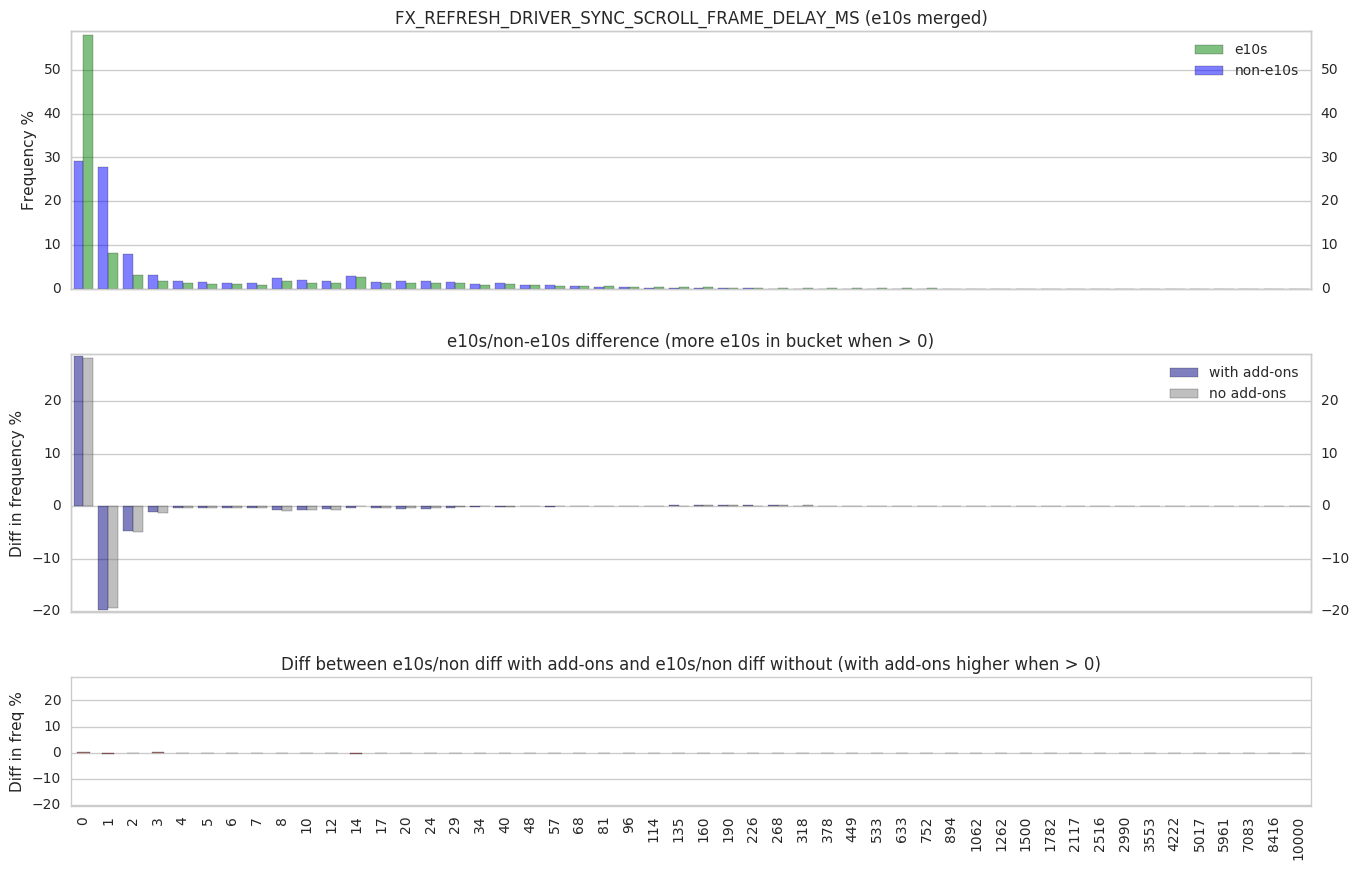

The probability that the distributions for FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS (e10s merged) (with add-ons) are differing by chance is 0.000.


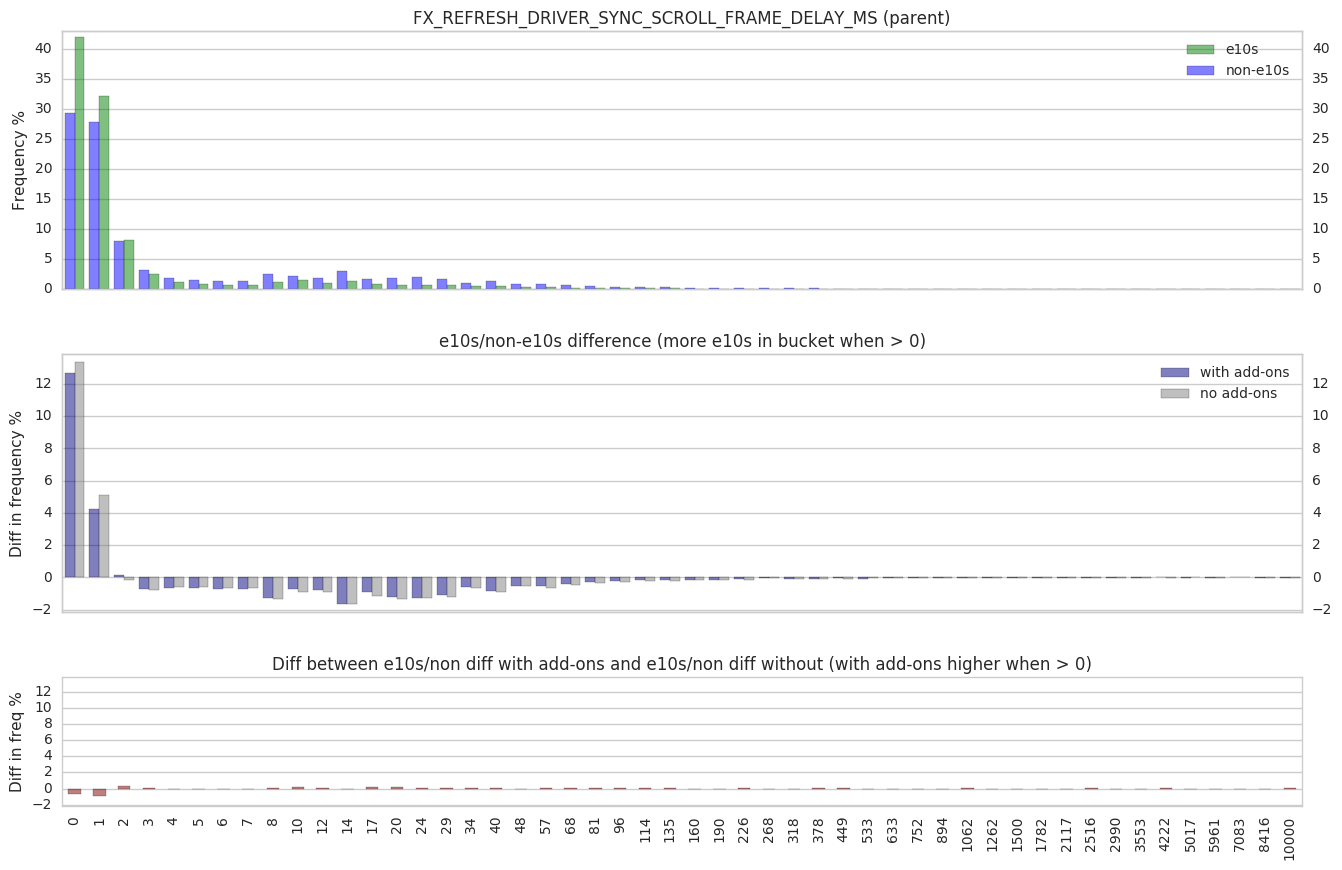

The probability that the distributions for FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS (parent) (with add-ons) are differing by chance is 0.000.


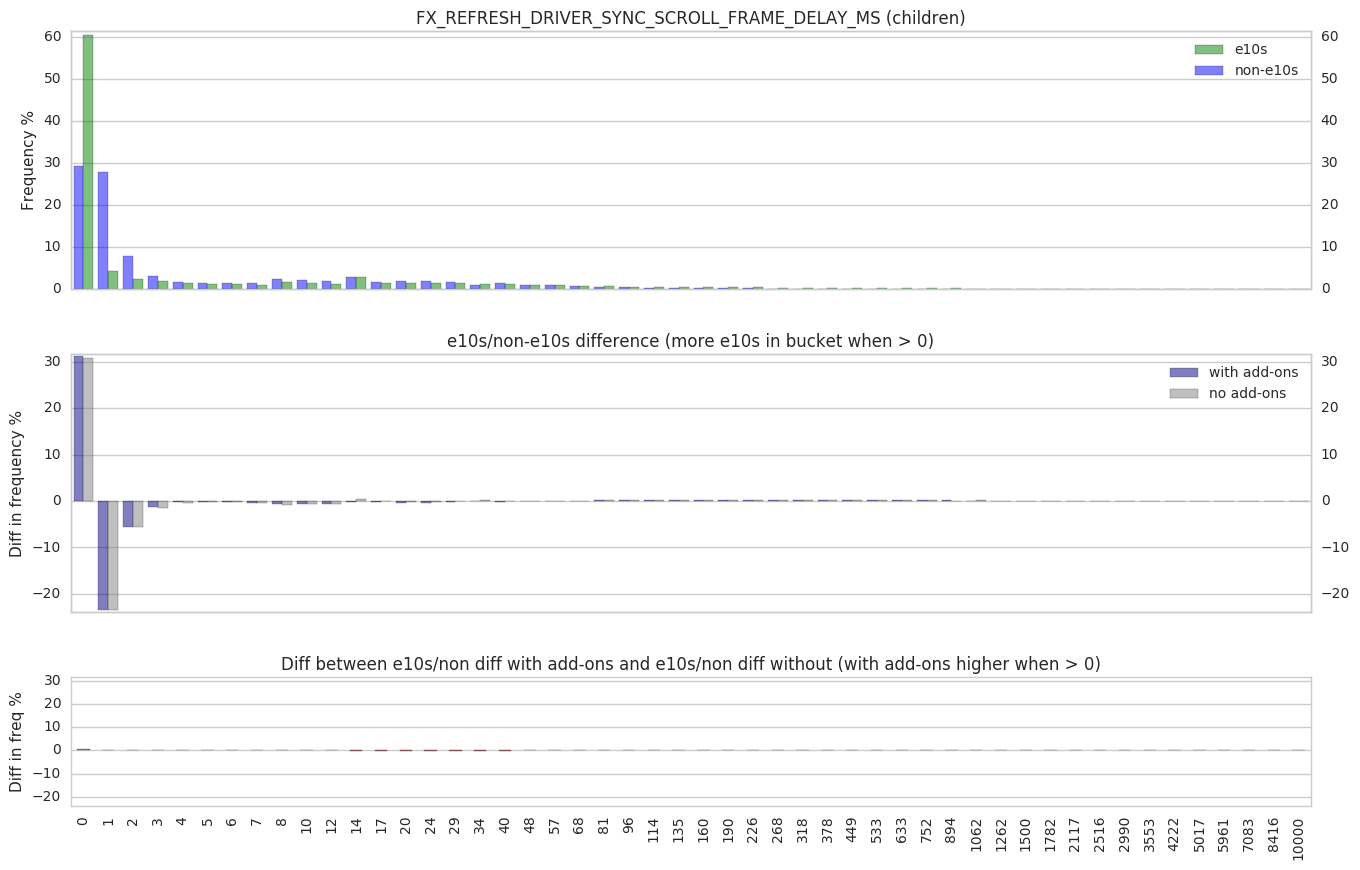

The probability that the distributions for FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS (children) (with add-ons) are differing by chance is 0.000.


In [33]:
compare_histograms(subset, "payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS")

## 1.7 Plugin jank

The plugin jank histograms are keyed by plugin. We find the most common plugin across all three histograms, and make the comparisons for that plugin.

In [34]:
plugin_hist = ["BLOCKED_ON_PLUGIN_MODULE_INIT_MS",
               "BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS",
               "BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS"]

def get_hist_plugins(ping):
    """ Find the keys used across all plugin histograms. """
    khist = ping.get("payload", {}).get("keyedHistograms", {})
    plugin_keys = []
    for h in plugin_hist:
        if h in khist:
            plugin_keys += map(lambda k: (h, k), khist[h].keys())
    return plugin_keys
        
plugin_hist_counts = subset.flatMap(get_hist_plugins).countByValue()
## Find the most commonly occurring plugin for each histogram.
top_plugins = {}
for h in plugin_hist:
    pl_for_hist = [(pl, n) for ((hist, pl), n) in plugin_hist_counts.iteritems()
                       if hist == h]
    top_plugins[h] = sorted(pl_for_hist, key=lambda (pl, n): n, reverse=True)[0]

for hist, (pl, n) in top_plugins.iteritems():
    print("Top plugin for {}: '{}'".format(hist, pl))

Top plugin for BLOCKED_ON_PLUGIN_MODULE_INIT_MS: 'Shockwave Flash24.0.0.194'
Top plugin for BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS: 'Shockwave Flash24.0.0.194'
Top plugin for BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS: 'Shockwave Flash24.0.0.194'


In [35]:
top_plugin = sorted(top_plugins.items(), key=lambda (pl, n): n, reverse=True)[0]
top_plugin = top_plugin[1][0]
print("Comparing plugin jank for '{}' (overall top plugin)".format(top_plugin))

Comparing plugin jank for 'Shockwave Flash24.0.0.194' (overall top plugin)


Comparison for [BLOCKED_ON_PLUGIN_MODULE_INIT_MS](https://dxr.mozilla.org/mozilla-central/search?q=BLOCKED_ON_PLUGIN_MODULE_INIT_MS+file%3AHistograms.json&redirect=true)/Shockwave Flash24.0.0.194 (with add-ons):

11547 non-e10s profiles have this histogram.
10735 e10s profiles have this histogram.
10735 e10s profiles have the parent histogram.
10012 e10s profiles have the children histogram.


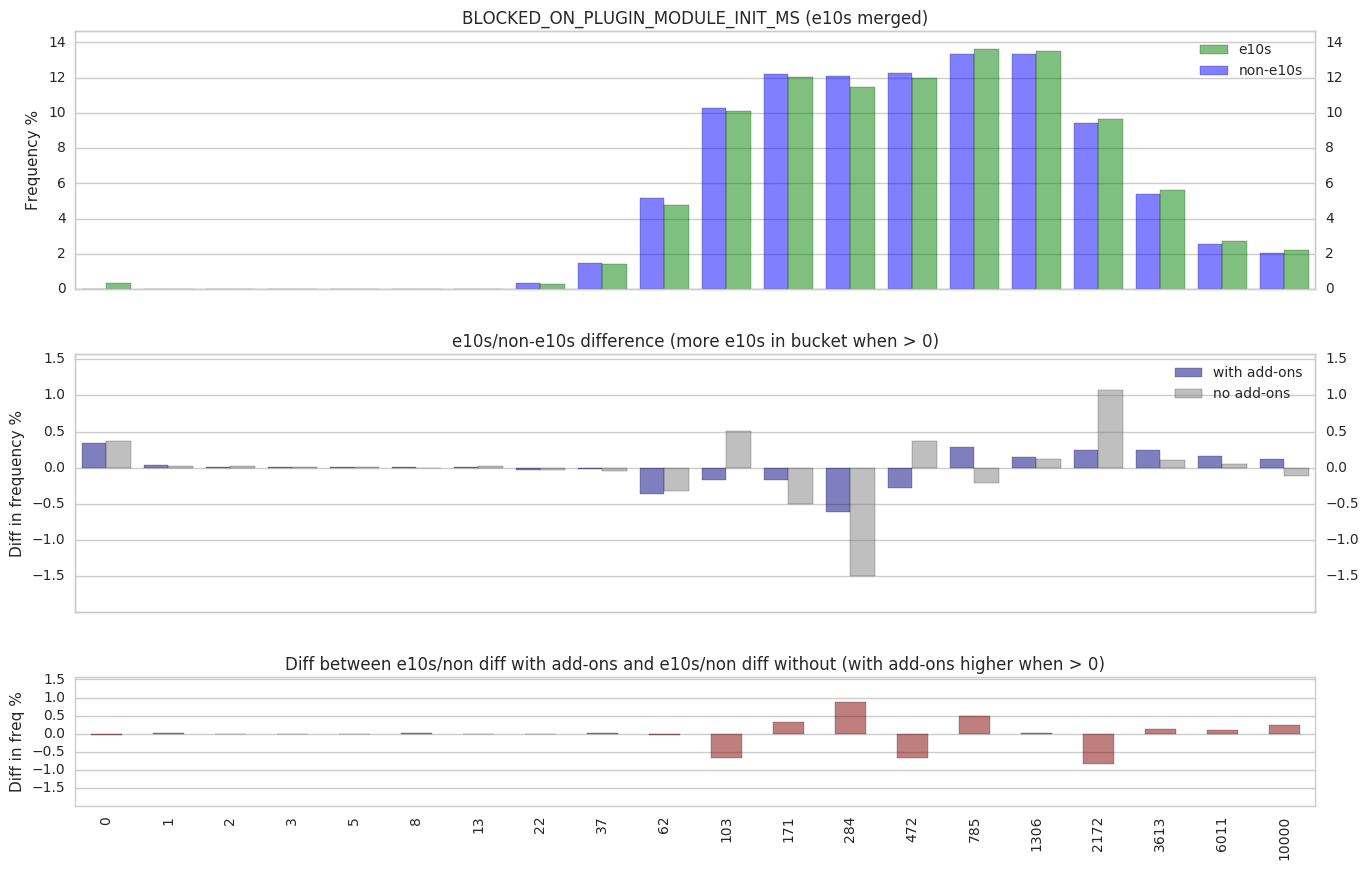

The probability that the distributions for BLOCKED_ON_PLUGIN_MODULE_INIT_MS (e10s merged) (with add-ons) are differing by chance is 0.036.


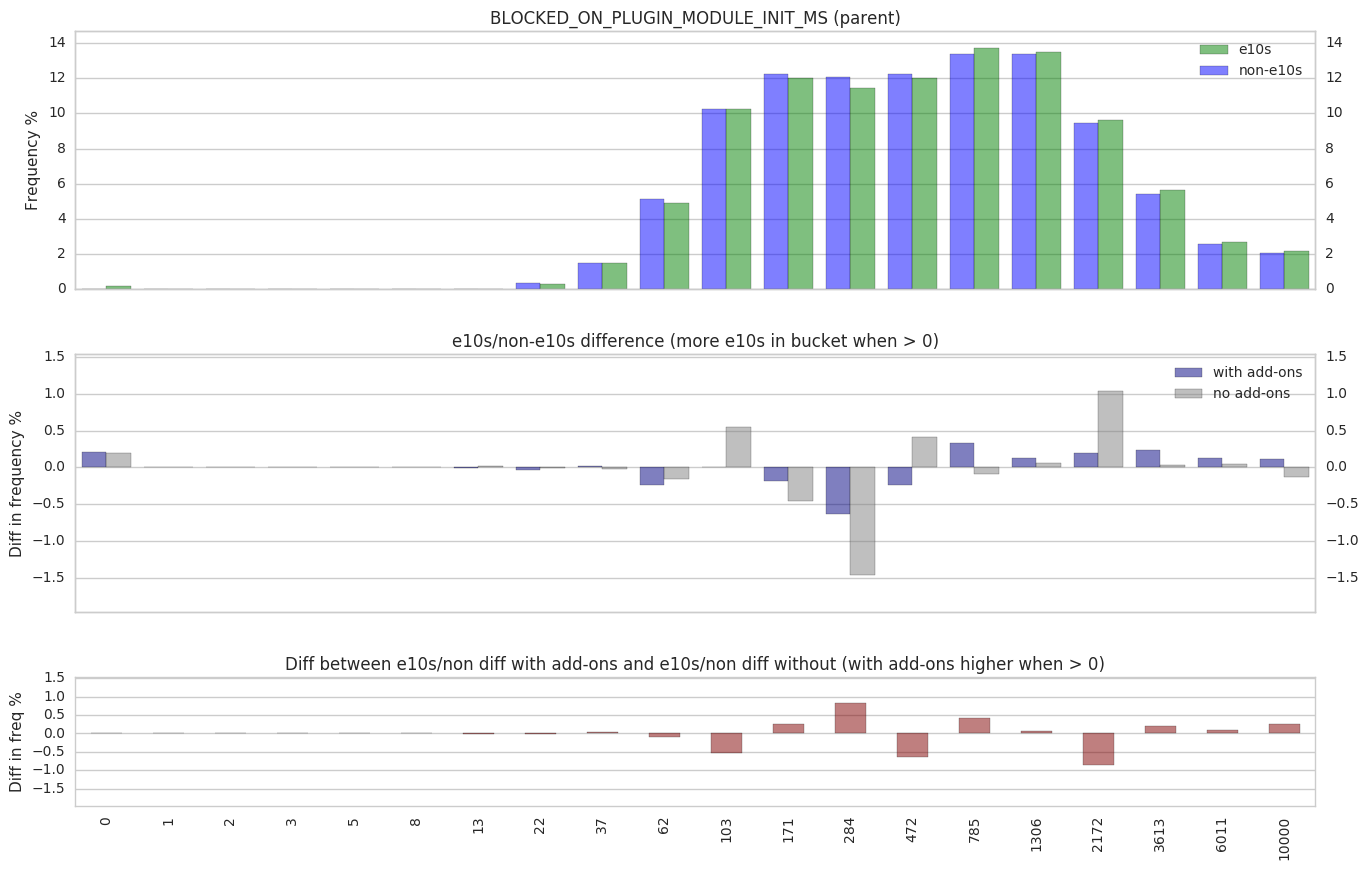

The probability that the distributions for BLOCKED_ON_PLUGIN_MODULE_INIT_MS (parent) (with add-ons) are differing by chance is 0.000.


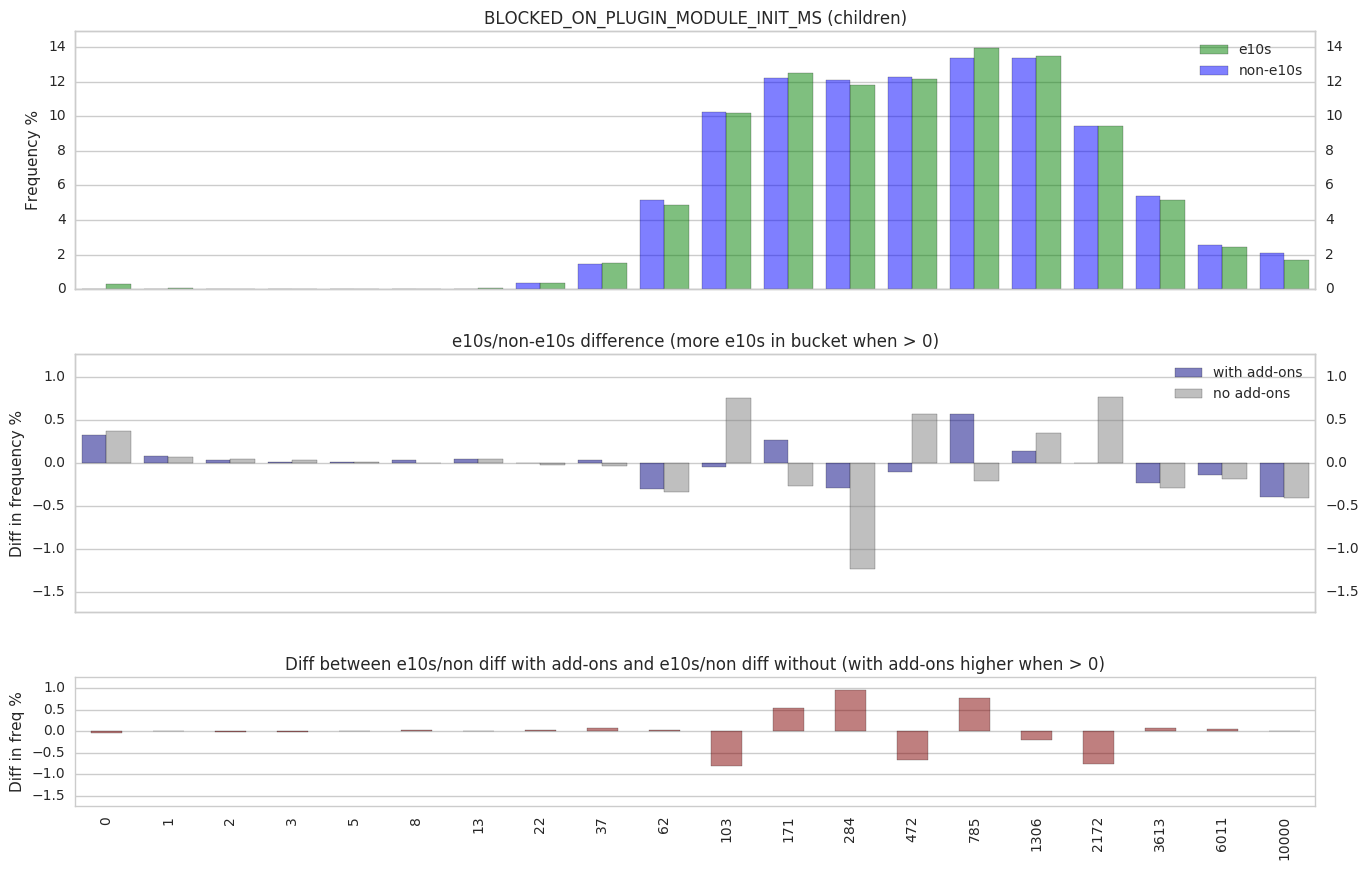

The probability that the distributions for BLOCKED_ON_PLUGIN_MODULE_INIT_MS (children) (with add-ons) are differing by chance is 0.045.


Comparison for [BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS](https://dxr.mozilla.org/mozilla-central/search?q=BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS+file%3AHistograms.json&redirect=true)/Shockwave Flash24.0.0.194 (with add-ons):

11547 non-e10s profiles have this histogram.
10012 e10s profiles have this histogram.
No e10s profiles have the parent histogram.
10012 e10s profiles have the children histogram.


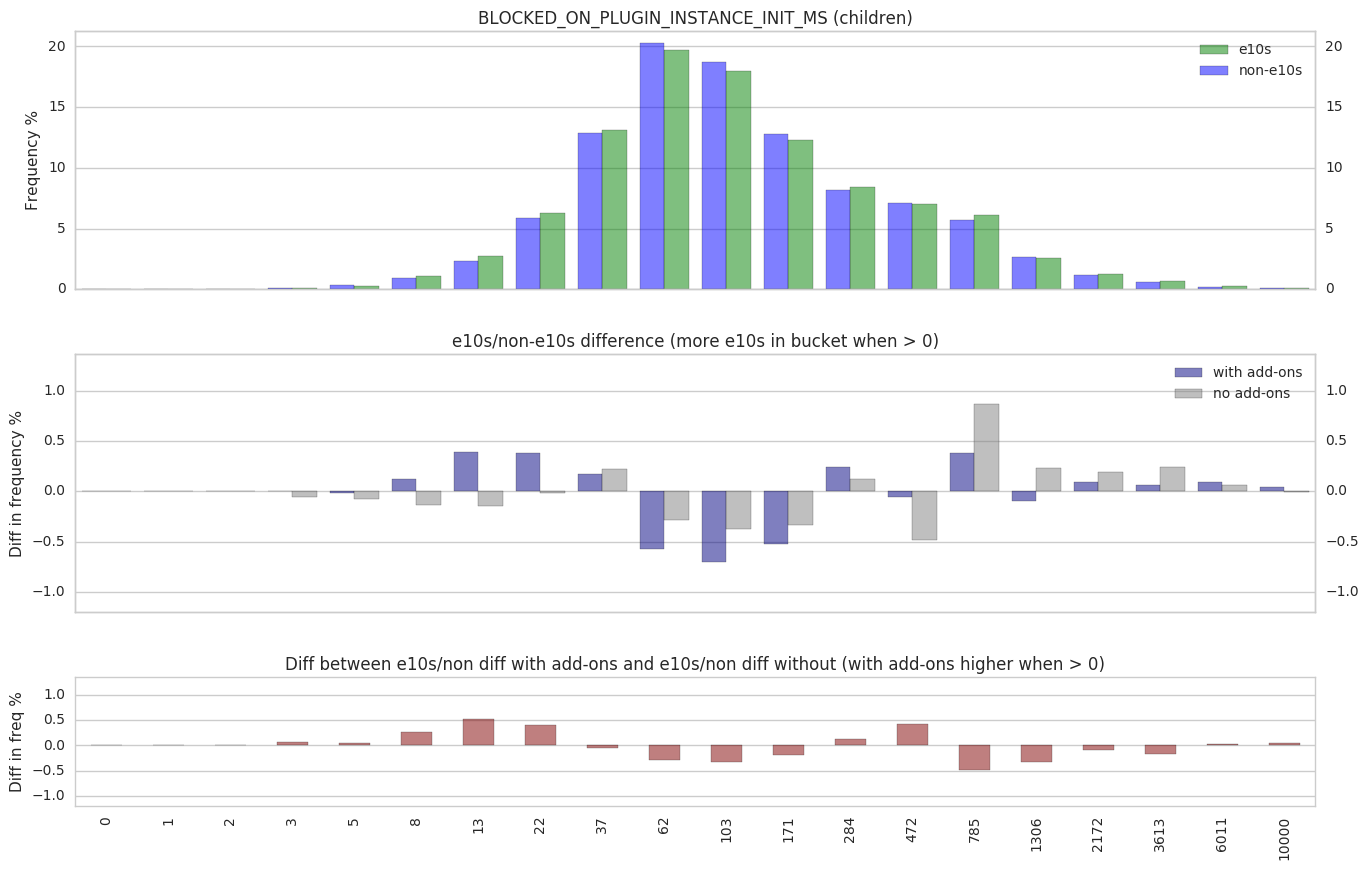

The probability that the distributions for BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS (children) (with add-ons) are differing by chance is 0.679.


Comparison for [BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS](https://dxr.mozilla.org/mozilla-central/search?q=BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS+file%3AHistograms.json&redirect=true)/Shockwave Flash24.0.0.194 (with add-ons):

11484 non-e10s profiles have this histogram.
9874 e10s profiles have this histogram.
No e10s profiles have the parent histogram.
9874 e10s profiles have the children histogram.


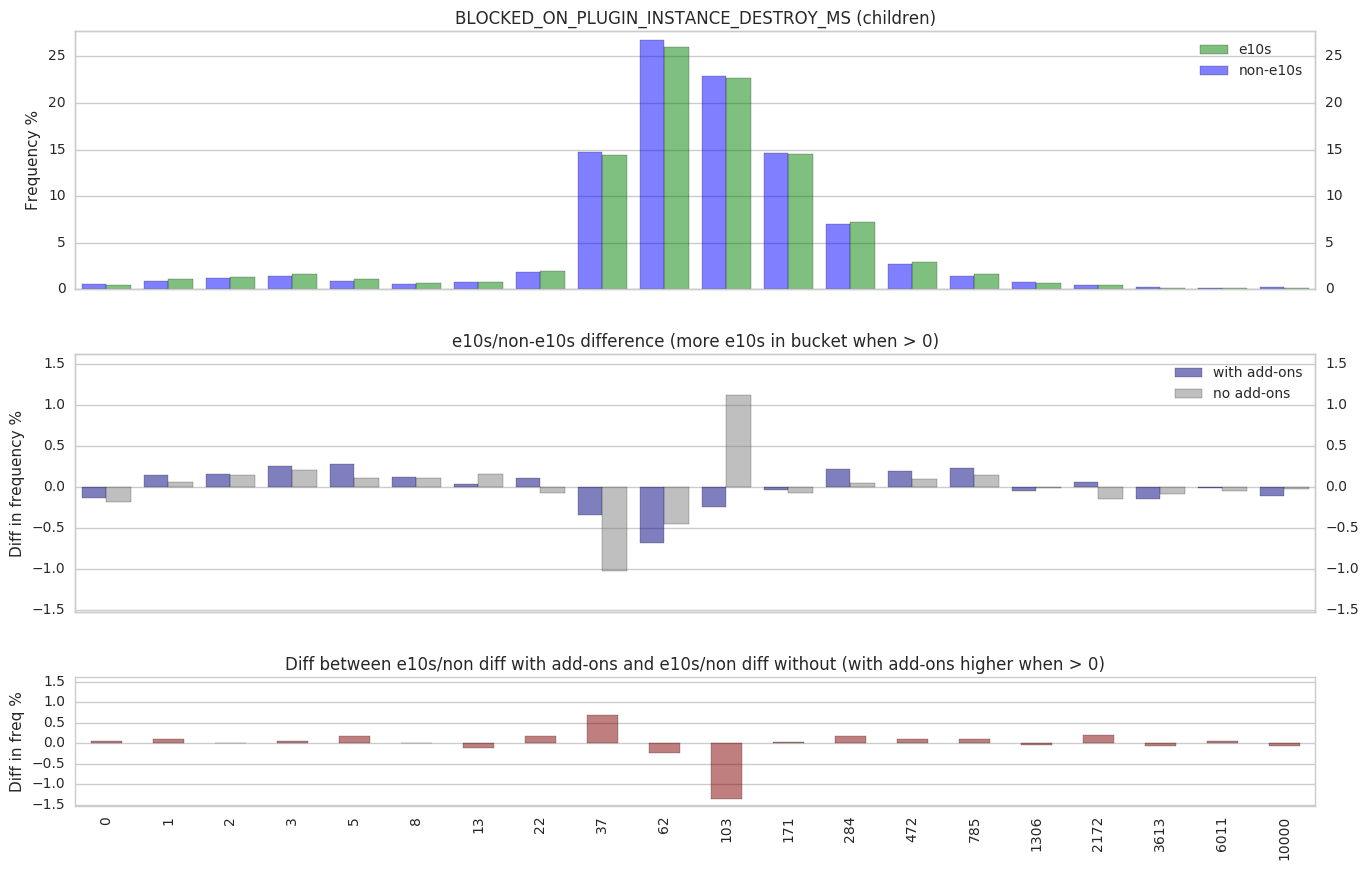

The probability that the distributions for BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS (children) (with add-ons) are differing by chance is 0.473.


In [36]:
compare_histograms(subset,
                   "payload/keyedHistograms/BLOCKED_ON_PLUGIN_MODULE_INIT_MS/{}".format(top_plugin),
                   "payload/keyedHistograms/BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS/{}".format(top_plugin),
                   "payload/keyedHistograms/BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS/{}".format(top_plugin))

## 1.8 Memory usage

Comparison for MEMORY_TOTAL (with add-ons):

125608 non-e10s profiles have this histogram.
122745 e10s profiles have this histogram.
122745 e10s profiles have the parent histogram.
No e10s profiles have the children histogram.


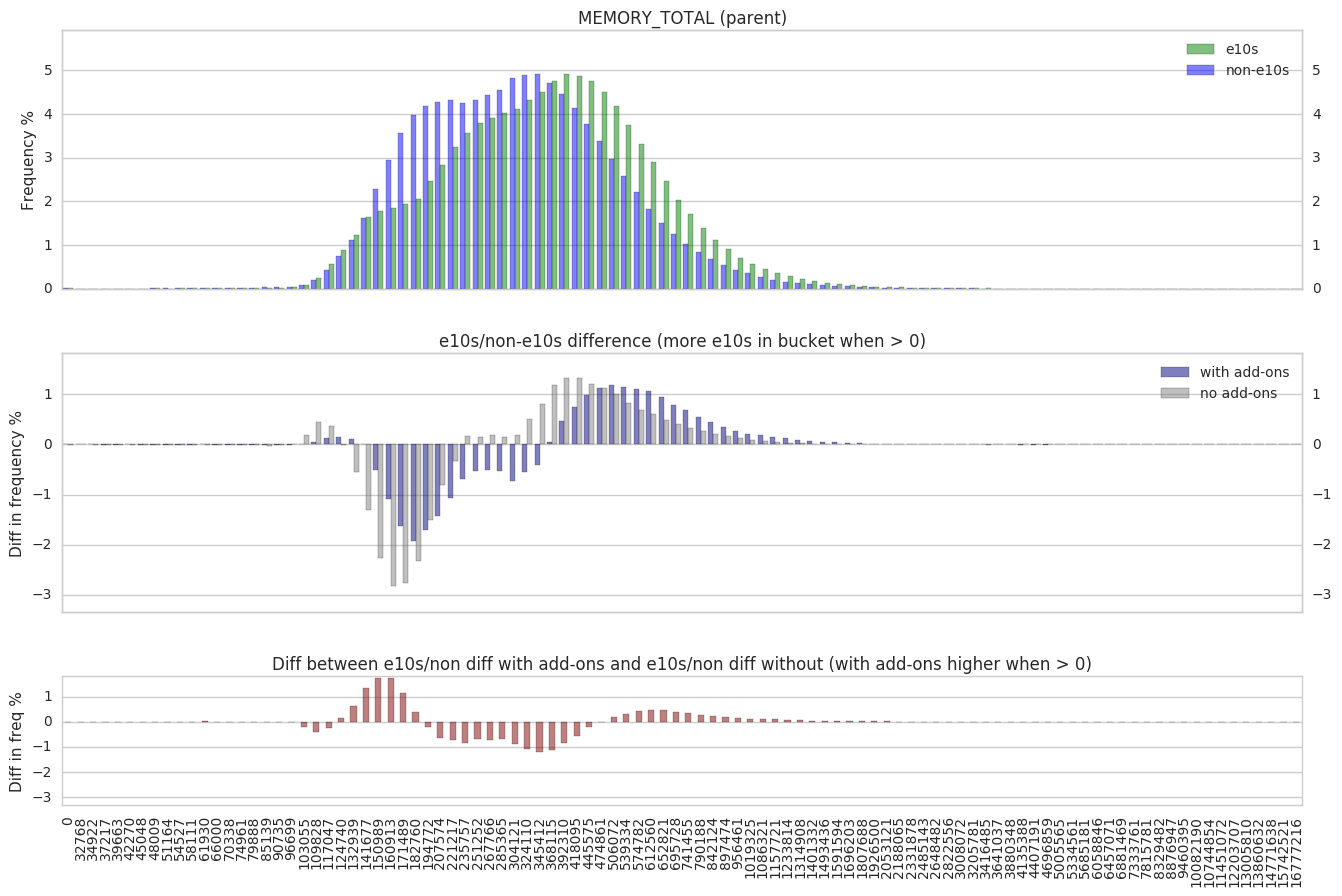

The probability that the distributions for MEMORY_TOTAL (parent) (with add-ons) are differing by chance is 0.000.


Comparison for MEMORY_VSIZE_MAX_CONTIGUOUS (with add-ons):

122971 non-e10s profiles have this histogram.
120973 e10s profiles have this histogram.
120973 e10s profiles have the parent histogram.
99824 e10s profiles have the children histogram.


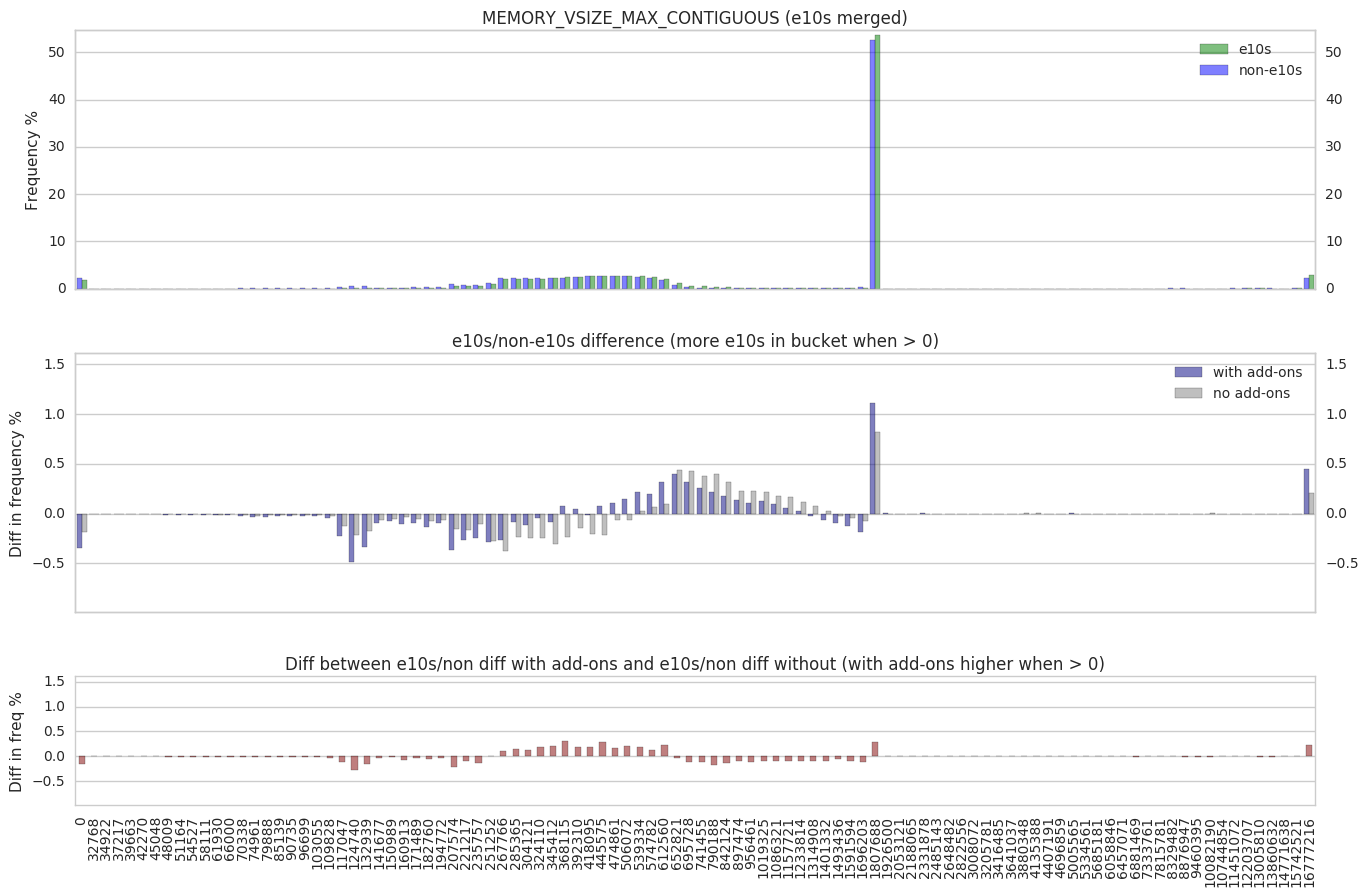

The probability that the distributions for MEMORY_VSIZE_MAX_CONTIGUOUS (e10s merged) (with add-ons) are differing by chance is 0.000.


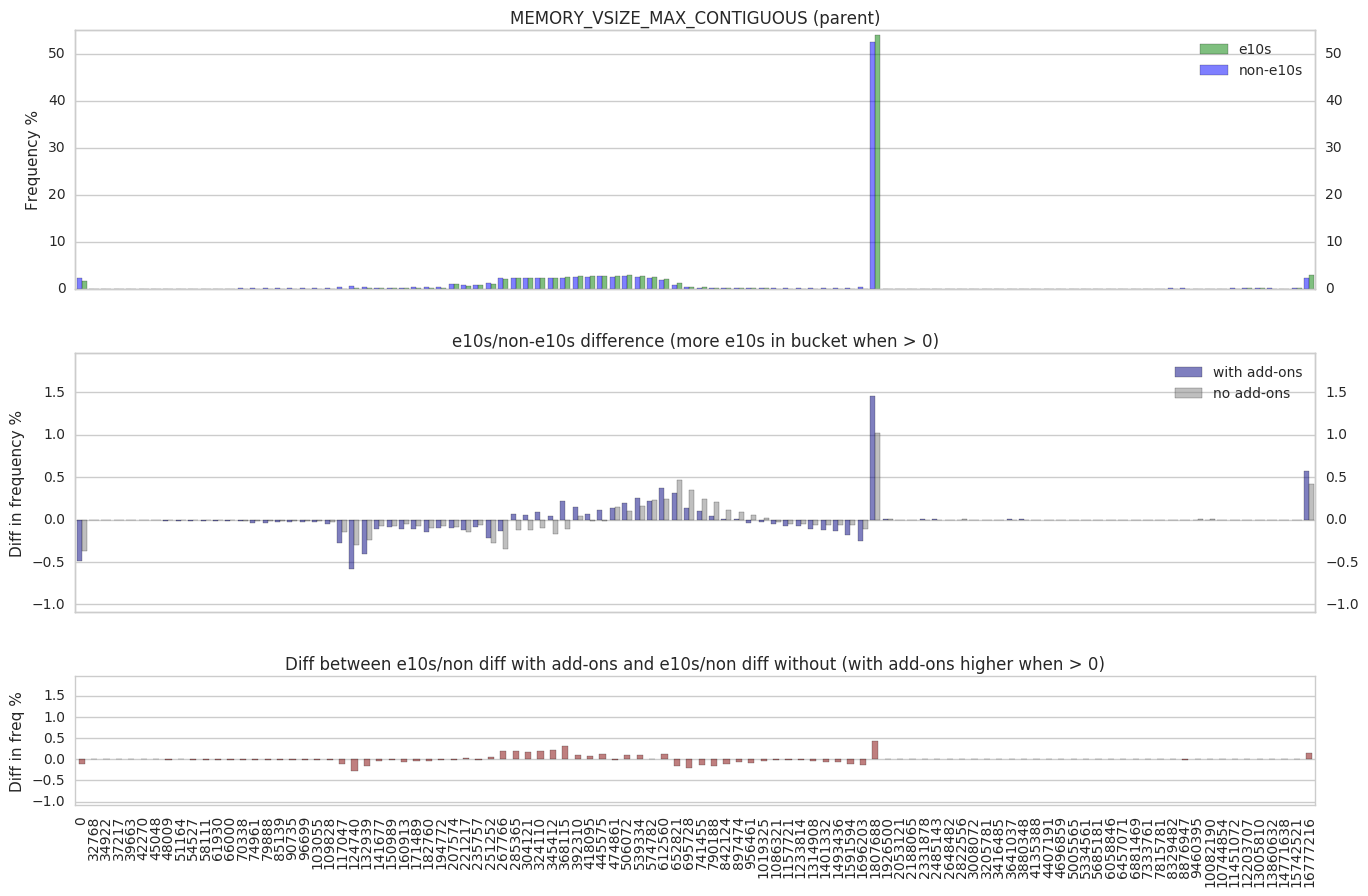

The probability that the distributions for MEMORY_VSIZE_MAX_CONTIGUOUS (parent) (with add-ons) are differing by chance is 0.000.


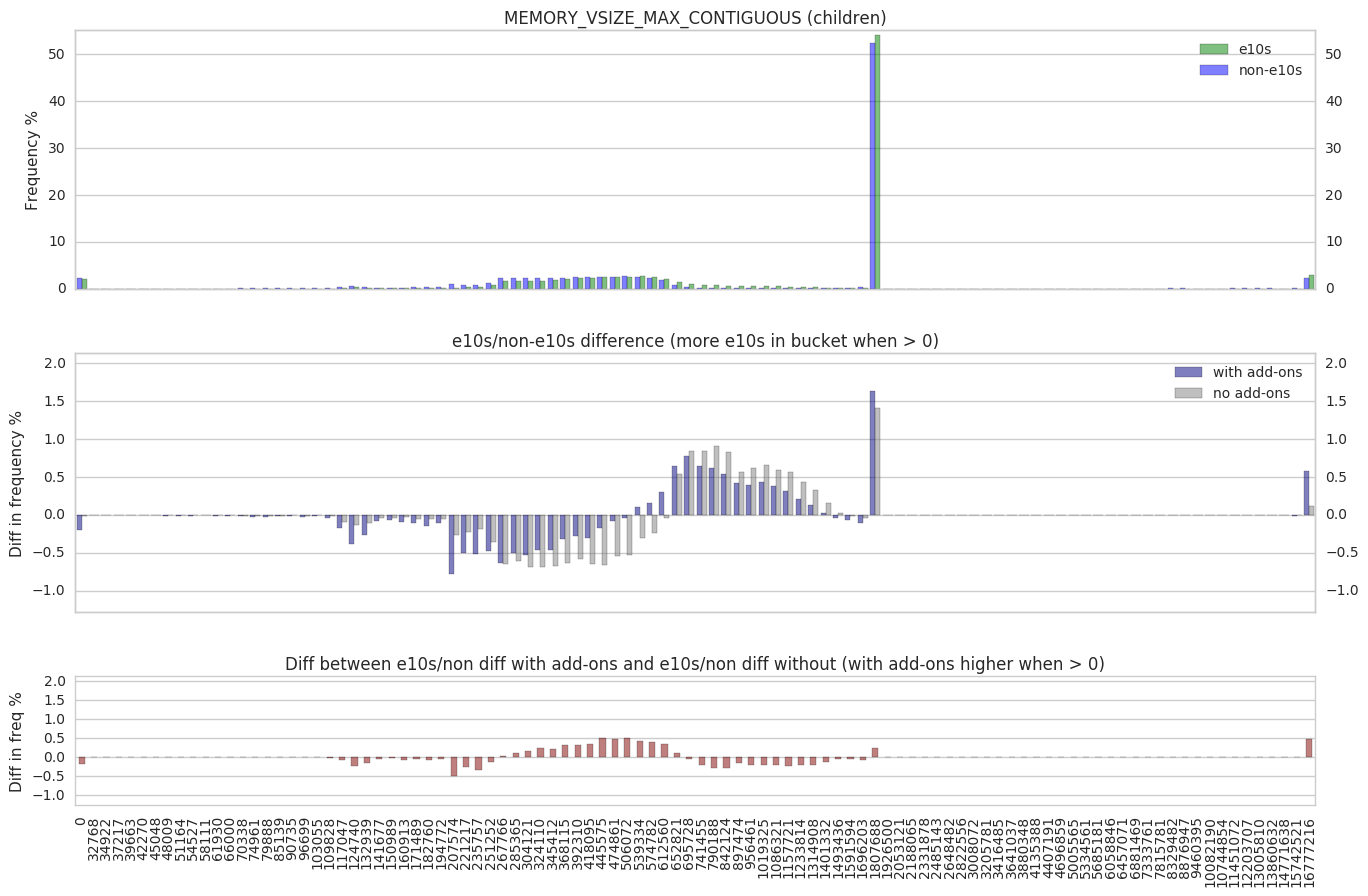

The probability that the distributions for MEMORY_VSIZE_MAX_CONTIGUOUS (children) (with add-ons) are differing by chance is 0.000.


In [37]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_TOTAL",
                   "payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS")

## 1.9 UI Smoothness

__Note__: `FX_TAB_SWITCH_TOTAL_MS` was renamed to `FX_TAB_SWITCH_TOTAL_E10S_MS` for e10s profiles.

In [38]:
def fix_hist(ping):
    """ Rename the histogram for e10s profiles. """
    hist = ping.get("payload", {}).get("histograms", {})
    if "FX_TAB_SWITCH_TOTAL_E10S_MS" in hist and "FX_TAB_SWITCH_TOTAL_MS" not in hist:
        hist["FX_TAB_SWITCH_TOTAL_MS"] = hist["FX_TAB_SWITCH_TOTAL_E10S_MS"]
    return ping

subset_fixed = subset.map(fix_hist)

Comparison for FX_TAB_SWITCH_TOTAL_MS (with add-ons):

78274 non-e10s profiles have this histogram.
75616 e10s profiles have this histogram.
75616 e10s profiles have the parent histogram.
No e10s profiles have the children histogram.


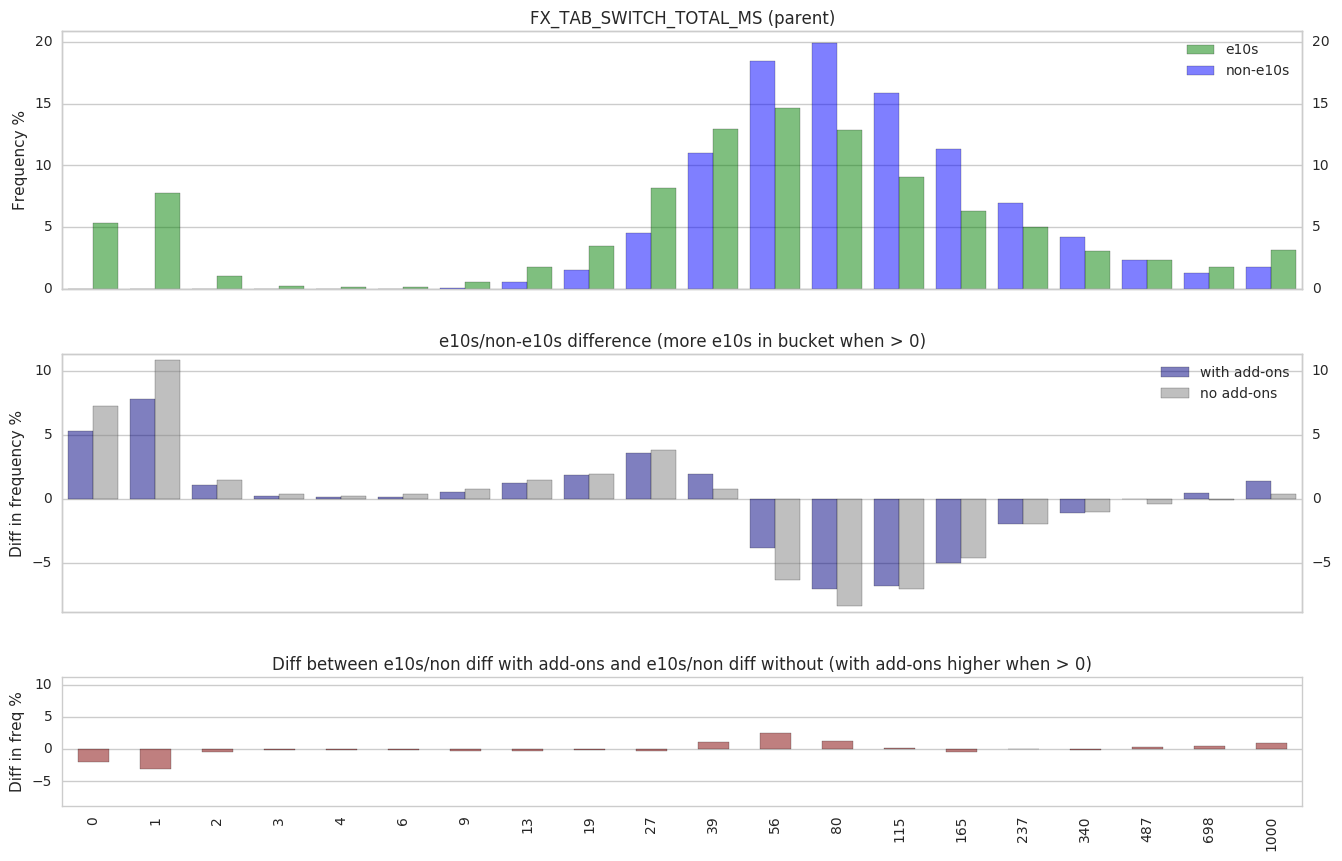

The probability that the distributions for FX_TAB_SWITCH_TOTAL_MS (parent) (with add-ons) are differing by chance is 0.000.


In [39]:
compare_histograms(subset_fixed, "payload/histograms/FX_TAB_SWITCH_TOTAL_MS")

## 1.11 Slow Scripts

In [40]:
compare_count_histograms(subset, "payload/histograms/SLOW_SCRIPT_PAGE_COUNT")

Comparison for count histogram SLOW_SCRIPT_PAGE_COUNT (with add-ons):

2508 non-e10s profiles have this histogram.
3098 e10s profiles have this histogram.

Comparison for SLOW_SCRIPT_PAGE_COUNT per hour (with add-ons):

- Median with e10s is 0.0417 units different from median without e10s.
- This is a relative difference of 13.6%.
- E10s group median is 0.3482, non-e10s group median is 0.3065.

The probability of this difference occurring purely by chance is 0.048.

For cohorts with no add-ons, median with e10s is 0.00208 units (0.6%) different from median without
- This is a relative difference of 0.6%.
- E10s group median is 0.3284, non-e10s group median is 0.3263.


## Slow Add-ons

In [41]:
def has_slow_scripts(histograms):
    hists = json.loads(histograms)
    return "SLOW_SCRIPT_PAGE_COUNT" in hists

has_slow_scripts = fun.udf(has_slow_scripts, st.BooleanType())

ss = addons_exp_dataset.filter(has_slow_scripts('histograms'))
ss.count()

29012

In [42]:
print "For profiles having slow scripts with add-ons and E10s ,"
test = get_top_addons(ss, "e10sCohort like 'addons%test%'", n_top=None)
test.head(10)

For profiles having slow scripts with add-ons and E10s ,
There were 1,157 distinct add-ons installed across the e10sCohort like 'addons%test%' cohort.


,guid,name,version,is_system,n_installs,pct_installed
1,aushelper@mozilla.org,Application Update Service Helper,1.0,True,3380,99.587507
2,webcompat@mozilla.org,Web Compat,1.0,True,3371,99.322334
3,e10srollout@mozilla.org,Multi-process staged rollout,1.6,True,3361,99.027696
4,firefox@getpocket.com,Pocket,1.0.5,True,3358,98.939305
5,{4ED1F68A-5463-4931-9384-8FFF5ED91D92},McAfee WebAdvisor,5.0.360.0,False,1080,31.820860
6,{d10d0bf8-f5b5-c8b4-a8b2-2b9879e08c5d},Adblock Plus,2.8.2,False,396,11.667649
7,helper-sig@savefrom.net,SaveFrom.net - helper,6.95,False,209,6.157926
8,{b9db16a4-6edc-47ec-a1f4-b86292ed211d},Video DownloadHelper,6.2.0,False,172,5.067767
9,_65Members_@download.fromdoctopdf.com,FromDocToPDF,7.102.10.4221,False,141,4.154390
10,{b9bfaf1c-a63f-47cd-8b9a-29526ced9060},Download YouTube Videos as MP4,1.8.8,False,115,3.388332


In [43]:
print "For profiles having slow scripts with add-ons and no E10s,"
control = get_top_addons(ss, "e10sCohort like 'addons%control%'", n_top=None)
control.head(10)

For profiles having slow scripts with add-ons and no E10s,
There were 2,132 distinct add-ons installed across the e10sCohort like 'addons%control%' cohort.


,guid,name,version,is_system,n_installs,pct_installed
1,aushelper@mozilla.org,Application Update Service Helper,1.0,True,10402,99.721983
2,webcompat@mozilla.org,Web Compat,1.0,True,10390,99.606941
3,e10srollout@mozilla.org,Multi-process staged rollout,1.6,True,10378,99.491899
4,firefox@getpocket.com,Pocket,1.0.5,True,10367,99.386444
5,{d10d0bf8-f5b5-c8b4-a8b2-2b9879e08c5d},Adblock Plus,2.8.2,False,1477,14.159716
6,helper-sig@savefrom.net,SaveFrom.net - helper,6.95,False,660,6.327294
7,{b9db16a4-6edc-47ec-a1f4-b86292ed211d},Video DownloadHelper,6.2.0,False,594,5.694564
8,_65Members_@download.fromdoctopdf.com,FromDocToPDF,7.102.10.4221,False,593,5.684977
9,{82AF8DCA-6DE9-405D-BD5E-43525BDAD38A},Skype,8.0.0.9103,False,570,5.464481
10,{4ED1F68A-5463-4931-9384-8FFF5ED91D92},McAfee WebAdvisor,5.0.360.0,False,485,4.649602


# Hangs

In [83]:
parent_hangs_by_group = subset.map(lambda x: {'parent_hangs':x.get('parent_hangs_per_minute', -1), 
                                              'cohort': x['cohort']})

child_hangs_by_group = subset.map(lambda x: {'child_hangs':x.get('child_hangs_per_minute', -1), 
                                              'cohort': x.get('cohort', {})})

In [87]:
parent_hangs = pd.DataFrame(parent_hangs_by_group.filter(lambda x: type(x['parent_hangs']) == float).collect())
child_hangs = pd.DataFrame(child_hangs_by_group.filter(lambda x: x.get('child_hangs') > 0).collect())


Mean Hangs per minute for parent and child (main and content)

In [76]:
parent_hangs.groupby('cohort').mean()

,parent_hangs
cohort,
addons-set51alladdons-control,9.045066
addons-set51alladdons-test,5.746015
control,8.337482
test,4.878284


In [90]:
child_hangs.groupby('cohort').mean()

,child_hangs
cohort,
addons-set51alladdons-control,3.902048
addons-set51alladdons-test,7.486035
control,3.558124
test,5.917792


Median Hangs per minute for parent and child

In [91]:
parent_hangs.groupby('cohort').median()

,parent_hangs
cohort,
addons-set51alladdons-control,3.545717
addons-set51alladdons-test,1.061144
control,2.648438
test,0.819567


In [92]:
child_hangs.groupby('cohort').median()

,child_hangs
cohort,
addons-set51alladdons-control,2.009979
addons-set51alladdons-test,2.946108
control,1.904762
test,1.890392
